09/25/2020

In [3]:
import pandas as pd
import os, glob,sys
import seaborn as sns
import numpy as np
import scipy.stats
import pybedtools
import matplotlib.pyplot as plt

# 0. setup lib

In [4]:
diseases =sorted( ['schizo', 'depress', 'bipolar', 'anxiety', 'attent',
 'personality', 'panic', 'traum', 'autism', 'ocd'])

In [5]:
print(sys.path)

['/Users/mguo123/Google Drive/1_khavari/noncancer_project/miseq/novogene_071420', '/Users/mguo123/opt/anaconda3/lib/python37.zip', '/Users/mguo123/opt/anaconda3/lib/python3.7', '/Users/mguo123/opt/anaconda3/lib/python3.7/lib-dynload', '', '/Users/mguo123/.local/lib/python3.7/site-packages', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/src/irf', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/MOODS_python-1.9.4.1-py3.7-macosx-10.9-x86_64.egg', '/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/mguo123/.ipython']


In [6]:
lib_csv = '../../psych_lib_info.csv'
lib_df = pd.read_csv(lib_csv,index_col=0)
lib_df['name_abbr']= lib_df.Chr + '_' + lib_df.Position.map(str)

print(lib_df.columns.values)
print(lib_df.shape)
print(lib_df.name_abbr.value_counts().shape)
lib_df[:5]

['name' 'X' 'Linked_SNP' 'Chr' 'Position' 'Index_SNP' 'Disease'
 'DHS_tissue' 'eGene' 'eQTL_tissue' 'Pval' 'source' 'RS' 'pos' 'info'
 'allele_type' 'allele' 'seq150_new' 'seq21_new' 'schizo' 'depress'
 'bipolar' 'anxiety' 'attent' 'personality' 'panic' 'traum' 'autism' 'ocd'
 'Ref' 'Alt' 'Type' 'Length' 'AnnoType' 'Consequence' 'ConsScore'
 'ConsDetail' 'GC' 'CpG' 'motifECount' 'motifEName' 'motifEHIPos'
 'motifEScoreChng' 'oAA' 'nAA' 'GeneID' 'FeatureID' 'GeneName' 'CCDS'
 'Intron' 'Exon' 'cDNApos' 'relcDNApos' 'CDSpos' 'relCDSpos' 'protPos'
 'relProtPos' 'Domain' 'Dst2Splice' 'Dst2SplType' 'minDistTSS'
 'minDistTSE' 'SIFTcat' 'SIFTval' 'PolyPhenCat' 'PolyPhenVal' 'priPhCons'
 'mamPhCons' 'verPhCons' 'priPhyloP' 'mamPhyloP' 'verPhyloP' 'bStatistic'
 'targetScan' 'mirSVR.Score' 'mirSVR.E' 'mirSVR.Aln' 'cHmmTssA'
 'cHmmTssAFlnk' 'cHmmTxFlnk' 'cHmmTx' 'cHmmTxWk' 'cHmmEnhG' 'cHmmEnh'
 'cHmmZnfRpts' 'cHmmHet' 'cHmmTssBiv' 'cHmmBivFlnk' 'cHmmEnhBiv'
 'cHmmReprPC' 'cHmmReprPCWk' 'cHmmQuies'

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (63,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,X,Linked_SNP,Chr,Position,Index_SNP,Disease,DHS_tissue,eGene,eQTL_tissue,...,dbscSNV.ada_score,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool,name_abbr
1,chr1.111243375.all_alt.G,75004,rs12085135,chr1,111243375,rs12061304,panic disorder,t-helper_17_cell,NaN,NaN,...,NaN,NaN,-0.197208,0.728,1,True,True,False,NaN,chr1_111243375
2,chr1.111243375.Ref.C,75004,rs12085135,chr1,111243375,rs12061304,panic disorder,t-helper_17_cell,NaN,NaN,...,NaN,NaN,-0.197208,0.728,1,True,True,False,NaN,chr1_111243375
3,chr1.113938499.all_alt.C,1977,rs74395031,chr1,113938499,rs115870915,"type 2 diabetes,Obsessive Compulsive Disorder",astrocyte_of_the_spinal_cord,NaN,NaN,...,NaN,NaN,0.309426,7.336,1,True,True,True,NaN,chr1_113938499
4,chr1.113938499.Ref.T,1977,rs74395031,chr1,113938499,rs115870915,"type 2 diabetes,Obsessive Compulsive Disorder",astrocyte_of_the_spinal_cord,NaN,NaN,...,NaN,NaN,0.309426,7.336,1,True,True,True,NaN,chr1_113938499
5,chr1.11712109.all_alt.T,569,rs2103665,chr1,11712109,rs115049252,schizo,spleen,NaN,NaN,...,NaN,NaN,0.193843,5.751,1,False,True,True,NaN,chr1_11712109


In [7]:
snp_loc_to_linked_rsid = pd.Series(lib_df.Linked_SNP.values, index=lib_df.name_abbr.values).to_dict()
snp_loc_to_index_rsid = pd.Series(lib_df.Index_SNP.values, index=lib_df.name_abbr.values).to_dict()


### get nearest_genes

In [8]:
# MAX_DIST = 100000

In [9]:
gene_region = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/gencode.v19.gene.bed',sep='\t',header=None)
gene_region.columns = ['chr','start','stop','gene']
gene_region_bed = pybedtools.BedTool.from_dataframe(gene_region).sort()

exon_region = pd.read_csv('/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/gencode.v19.exon.bed',sep='\t',header=None)
exon_region.columns = ['chr','start','stop','gene']
exon_region_bed = pybedtools.BedTool.from_dataframe(exon_region).sort()

TSS_file = '/Users/mguo123/Google Drive/1_khavari/omics_project-LD/pan_omics/data/external/TSS_annon_hg19.csv'
TSS_df = pd.read_csv(TSS_file,index_col=0)
TSS_df['stop'] = TSS_df['loc']+1
TSS_df = TSS_df[['chr', 'loc','stop','TSS']]
TSS_df.columns = ['chr','start','stop','TSS']
TSS_bed = pybedtools.BedTool.from_dataframe(TSS_df).sort()
TSS_df[:5]

,chr,start,stop,TSS
0,chr1,1846266,1846267,CALML6
1,chr1,231376933,231376934,C1orf131
2,chr1,241683061,241683062,FH
3,chr1,120202421,120202422,PHGDH
4,chr1,204135465,204135466,REN


In [10]:
gwas_df = lib_df[['Chr','Position','name_abbr']]
gwas_df.columns = ['chr','start','name']
gwas_df['stop'] = gwas_df.start +1
gwas_df = gwas_df[['chr','start','stop','name']]
gwas_bed = pybedtools.BedTool.from_dataframe(gwas_df).sort()
gwas_bed.to_dataframe()[:5]

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,chrom,start,end,name
0,chr1,2069681,2069682,chr1_2069681
1,chr1,2069681,2069682,chr1_2069681
2,chr1,2337032,2337033,chr1_2337032
3,chr1,2337032,2337033,chr1_2337032
4,chr1,2337277,2337278,chr1_2337277


In [11]:
gwas_ngene_bed = gwas_bed.closest(TSS_bed,d=True)
gwas_ngene_bed.saveas(os.path.join('../../psych_lib_ngene_TSS.bed'))
gwas_ngene_df = gwas_ngene_bed.to_dataframe()
gwas_ngene_df = gwas_ngene_df[['name','thickEnd','itemRgb']]
gwas_ngene_df.columns = ['snp_id','TSS','distance']
gwas_ngene_df = gwas_ngene_df.merge(lib_df, how='left', left_on='snp_id',right_on='name_abbr')
# gwas_ngene_df = gwas_ngene_df[gwas_ngene_df.distance < MAX_DIST]
print(gwas_ngene_df.TSS.unique().shape)
gwas_ngene_df[:5]


(746,)


,snp_id,TSS,distance,name,X,Linked_SNP,Chr,Position,Index_SNP,Disease,...,dbscSNV.ada_score,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool,name_abbr
0,chr1_2069681,AL590822.2,51556,chr1.2069681.all_alt.T,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
1,chr1_2069681,AL590822.2,51556,chr1.2069681.Ref.C,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
2,chr1_2069681,AL590822.2,51556,chr1.2069681.all_alt.T,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
3,chr1_2069681,AL590822.2,51556,chr1.2069681.Ref.C,1545,rs3753242,chr1,2069681,rs3753242,Schizophrenia,...,NaN,NaN,-0.131842,1.130,1,False,True,True,True,chr1_2069681
4,chr1_2337032,PEX10,8204,chr1.2337032.all_alt.T,451,rs1129171,chr1,2337032,NaN,schizo,...,NaN,NaN,-0.093925,1.458,1,False,True,True,NaN,chr1_2337032


In [12]:
snp_to_annongene_dict = pd.Series(lib_df.GeneName.values, index=lib_df.name_abbr.values).to_dict()


In [13]:
snp_to_ngene_df = gwas_ngene_df[['snp_id','TSS']].drop_duplicates()#.snp_id.value_counts()
snp_to_ngene_dict = pd.Series(snp_to_ngene_df.TSS.values, index=snp_to_ngene_df.snp_id.values).to_dict()



In [14]:
#one case with 2
print(gwas_ngene_df[gwas_ngene_df.snp_id=='chr14_104029449'].TSS.unique())
snp_to_ngene_dict['chr14_104029449'] = 'APOPT1'

['APOPT1' 'RP11-73M18.2']


In [15]:
len(snp_to_ngene_dict)

2221

# 1. get results

In [16]:
glob.glob('mpraanalyze_*comp_filt.csv')

['mpraanalyze_SL_comp_filt.csv',
 'mpraanalyze_H9D2_comp_filt.csv',
 'mpraanalyze_H9D10_comp_filt.csv',
 'mpraanalyze_HEK293_comp_filt.csv',
 'mpraanalyze_AST1_comp_filt.csv',
 'mpraanalyze_H9D4_comp_filt.csv',
 'mpraanalyze_H9D0_comp_filt.csv',
 'mpraanalyze_SLC_comp_filt.csv']

In [17]:
test_df = pd.read_csv('mpraanalyze_SL_comp_filt.csv',index_col=0)
test_df[:5]

,rowname,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,neglog10_p,...,Sngl10000bp,dbscSNV.ada_score,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool
1,chr2_73612102,22.113821,2.569530e-06,6.298204e-04,1,4,3,2,2.394077,5.590146,...,534,NaN,NaN,0.068726,3.743,1,False,True,False,True
2,chr2_73612102,22.113821,2.569530e-06,6.298204e-04,1,4,3,2,2.394077,5.590146,...,534,NaN,NaN,0.068726,3.743,1,False,True,False,True
3,chr22_39955873,42.639249,6.582521e-11,2.420174e-08,1,6,3,2,1.241493,10.181608,...,538,NaN,NaN,-0.005500,2.540,1,False,True,True,True
4,chr22_39955873,42.639249,6.582521e-11,2.420174e-08,1,6,3,2,1.241493,10.181608,...,538,NaN,NaN,-0.005500,2.540,1,False,True,True,True
5,chr1_11858036,13.060043,3.016626e-04,4.159173e-02,1,12,3,2,1.351650,3.520479,...,600,NaN,NaN,0.451207,8.916,1,False,True,True,True


In [18]:
test_df.fdr.describe()

count    3.000000e+01
mean     9.750098e-03
std      1.506082e-02
min      8.892420e-15
25%      8.062761e-09
50%      6.298204e-04
75%      2.484091e-02
max      4.159173e-02
Name: fdr, dtype: float64

In [19]:
final_df = pd.DataFrame()
for mpra_res_file in glob.glob('mpraanalyze_*comp.csv'):
    tissue = mpra_res_file.split('_')[1]
    res_df = pd.read_csv(mpra_res_file,index_col=0)
    res_df = res_df.merge(lib_df, how='left',left_on='rowname',right_on='name_abbr')
    res_df['tissue'] = tissue
    print(tissue,res_df.shape)
    final_df = pd.concat([final_df, res_df], axis=0)

AST1 (4257, 152)
H9D2 (4297, 152)
H9D10 (4267, 152)
H9D4 (4305, 152)
H9D0 (4221, 152)
HEK293 (4382, 152)
SLC (4325, 152)
SL (4325, 152)


In [20]:
print(final_df.columns.values)
final_df.shape

['rowname' 'statistic' 'pval' 'fdr' 'df.test' 'df.dna' 'df.rna.full'
 'df.rna.red' 'logFC' 'neglog10_p' 'neglog10_p_x_logFC' 'name' 'X'
 'Linked_SNP' 'Chr' 'Position' 'Index_SNP' 'Disease' 'DHS_tissue' 'eGene'
 'eQTL_tissue' 'Pval' 'source' 'RS' 'pos' 'info' 'allele_type' 'allele'
 'seq150_new' 'seq21_new' 'schizo' 'depress' 'bipolar' 'anxiety' 'attent'
 'personality' 'panic' 'traum' 'autism' 'ocd' 'Ref' 'Alt' 'Type' 'Length'
 'AnnoType' 'Consequence' 'ConsScore' 'ConsDetail' 'GC' 'CpG'
 'motifECount' 'motifEName' 'motifEHIPos' 'motifEScoreChng' 'oAA' 'nAA'
 'GeneID' 'FeatureID' 'GeneName' 'CCDS' 'Intron' 'Exon' 'cDNApos'
 'relcDNApos' 'CDSpos' 'relCDSpos' 'protPos' 'relProtPos' 'Domain'
 'Dst2Splice' 'Dst2SplType' 'minDistTSS' 'minDistTSE' 'SIFTcat' 'SIFTval'
 'PolyPhenCat' 'PolyPhenVal' 'priPhCons' 'mamPhCons' 'verPhCons'
 'priPhyloP' 'mamPhyloP' 'verPhyloP' 'bStatistic' 'targetScan'
 'mirSVR.Score' 'mirSVR.E' 'mirSVR.Aln' 'cHmmTssA' 'cHmmTssAFlnk'
 'cHmmTxFlnk' 'cHmmTx' 'cHmmTxWk' '

(34379, 152)

In [21]:
final_df_filt = final_df[final_df.fdr<0.05]
# p_thres = 0.05/lib_df.shape[0]
# final_df_filt = final_df[final_df.pval<p_thres]

final_df_filt.shape

(308, 152)

In [22]:
final_df_filt[['pval','fdr']].describe()

,pval,fdr
count,3.080000e+02,3.080000e+02
mean,1.329186e-04,1.255510e-02
std,1.944443e-04,1.558902e-02
min,3.012246e-22,6.632965e-19
25%,8.055274e-09,2.217214e-06
50%,2.111022e-05,3.073826e-03
75%,2.206131e-04,2.487921e-02
max,7.477046e-04,4.980166e-02


In [23]:
final_df[:5]

,rowname,statistic,pval,fdr,df.test,df.dna,df.rna.full,df.rna.red,logFC,neglog10_p,...,dbscSNV.rf_score,RawScore,PHRED,num_disease,disease_interest,pass_thres_low,pass_thres,CADD_score_bool,name_abbr,tissue
0,chr8_22479988,16.259887,0.000055,0.012187,1,8,3,2,4.747394,4.257898,...,NaN,0.049494,3.420,1,False,True,False,True,chr8_22479988,AST1
1,chr8_22479988,16.259887,0.000055,0.012187,1,8,3,2,4.747394,4.257898,...,NaN,0.049494,3.420,1,False,True,False,True,chr8_22479988,AST1
2,chr2_73612234,14.546391,0.000137,0.020121,1,12,3,2,1.887399,3.864072,...,NaN,0.194449,5.760,1,False,True,False,True,chr2_73612234,AST1
3,chr2_73612234,14.546391,0.000137,0.020121,1,12,3,2,1.887399,3.864072,...,NaN,0.194449,5.760,1,False,True,False,True,chr2_73612234,AST1
4,chr10_70772168,14.636876,0.000130,0.020121,1,12,3,2,1.766928,3.884925,...,NaN,-0.062721,1.787,1,True,True,False,NaN,chr10_70772168,AST1


In [24]:
final_df_filt = final_df_filt[diseases+['rowname','GeneName','tissue','pval','fdr','logFC','DHS_tissue','PHRED']]
final_df_filt['ngene'] = final_df_filt.rowname.map(snp_to_ngene_dict)
final_df_filt.fillna('',inplace=True)

In [25]:
final_df_filt


,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,rowname,GeneName,tissue,pval,fdr,logFC,DHS_tissue,PHRED,ngene
0,0,0,0,0,0,0,0,0,1,0,chr8_22479988,CCAR2,AST1,5.522070e-05,1.218721e-02,4.747394,astrocyte_of_the_cerebellum,3.420,CCAR2
1,0,0,0,0,0,0,0,0,1,0,chr8_22479988,CCAR2,AST1,5.522070e-05,1.218721e-02,4.747394,astrocyte_of_the_cerebellum,3.420,CCAR2
2,0,0,0,0,0,0,0,0,1,0,chr2_73612234,ALMS1,AST1,1.367503e-04,2.012053e-02,1.887399,astrocyte_of_the_spinal_cord,5.760,ALMS1
3,0,0,0,0,0,0,0,0,1,0,chr2_73612234,ALMS1,AST1,1.367503e-04,2.012053e-02,1.887399,astrocyte_of_the_spinal_cord,5.760,ALMS1
4,0,0,0,0,1,0,0,0,0,0,chr10_70772168,KIAA1279,AST1,1.303391e-04,2.012053e-02,1.766928,b_cell,1.787,KIAA1279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,1,0,0,0,0,0,0,0,0,0,chr14_91287534,CTD-3035D6.2,SL,2.336839e-15,1.718355e-12,-3.230378,astrocyte_of_the_cerebellum,6.467,TTC7B
4321,0,0,0,0,1,0,0,0,0,0,chr14_67446561,GPHN,SL,4.031015e-18,8.892420e-15,-2.845233,t-helper_2_cell,9.487,FAM71D
4322,0,0,0,0,1,0,0,0,0,0,chr14_67446561,GPHN,SL,4.031015e-18,8.892420e-15,-2.845233,t-helper_2_cell,9.487,FAM71D
4323,0,0,0,0,0,0,0,0,1,0,chr5_140203432,PCDHA5,SL,7.085315e-15,3.907551e-12,-5.993834,cd14-positive_monocyte,15.930,PCDHA5


# 2. analyze

### compare the PHRED SCORES OF THE MPRA significant genes, and the ones originally tested set

In [21]:
# look at distrbutitions'
phred_df = lib_df[['PHRED','name_abbr']].drop_duplicates()
phred_df.columns = ['PHRED','rowname']
phred_df['type'] = 'library'
phred_df.PHRED.describe()

count    2221.000000
mean        5.486179
std         5.272465
min         0.002000
25%         1.518000
50%         4.050000
75%         7.765000
max        69.000000
Name: PHRED, dtype: float64

In [22]:
phred_df_sig = final_df_filt[['PHRED','rowname']].drop_duplicates()
phred_df_sig['type'] = 'sig'
phred_df_sig.PHRED.describe()

count    92.000000
mean      5.949565
std       5.330002
min       0.096000
25%       1.536000
50%       4.881000
75%       8.698500
max      22.700000
Name: PHRED, dtype: float64

In [34]:
scipy.stats.ks_2samp(phred_df.PHRED.values, phred_df_sig.PHRED.values)

Ks_2sampResult(statistic=0.07502985337587847, pvalue=0.6731415821600355)

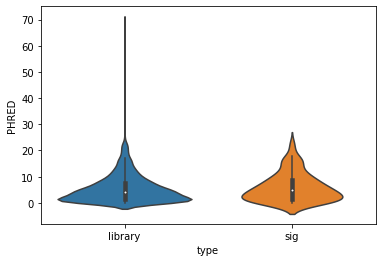

In [35]:
phred_df_all = pd.concat([phred_df,phred_df_sig],axis=0)
sns.violinplot(x="type", y="PHRED", data=phred_df_all)

they aren'e significant

# TISSUE TYPE


In [192]:
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt

In [185]:
tissue_snp_df = final_df_filt[['rowname','tissue']].drop_duplicates()
tissue_snp_df['bool'] = 1
tissue_snp_df = tissue_snp_df.pivot(index='rowname',columns='tissue',values='bool').fillna(0)
tissue_snp_df

tissue,AST1,H9D0,H9D10,H9D2,H9D4,HEK293,SL,SLC
rowname,,,,,,,,
chr10_104359350,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
chr10_104574642,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
chr10_104767185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
chr10_34079685,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
chr10_70772168,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
chr7_50720335,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
chr8_22479988,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
chr8_38326046,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [191]:
tissue_snp_df_HEK_AST_H9 = tissue_snp_df[['AST1','HEK293']]
tissue_snp_df_HEK_AST_H9['H9'] = tissue_snp_df[['H9D0', 'H9D10', 'H9D2', 'H9D4',  'SL', 'SLC']].max(axis=1)
HEK_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.HEK293==1].index)
H9_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.H9==1].index)
AST_set = set(tissue_snp_df_HEK_AST_H9[tissue_snp_df_HEK_AST_H9.AST1==1].index)


/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [188]:
tissue_snp_df_HEK_AST_H9.describe()

tissue,AST1,HEK293,H9
count,92.000000,92.000000,92.000000
mean,0.108696,0.086957,0.923913
std,0.312963,0.283315,0.266590
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,0.000000,0.000000,1.000000
75%,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000


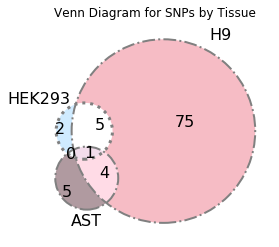

In [201]:
vd3=venn3([set(HEK_set),set(H9_set),set(AST_set)],
 set_labels=('HEK293','H9','AST'),
 set_colors=('#c4e6ff','#F4ACB7','#9D8189'), 
 alpha = 0.8)
c=venn3_circles([set(HEK_set), set(H9_set),set(AST_set)], linestyle='-.', linewidth=2, color='grey')
for text in vd3.set_labels:
 text.set_fontsize(16);
for text in vd3.subset_labels:
 text.set_fontsize(16)
plt.title('Venn Diagram for SNPs by Tissue')#,fontname='Times New Roman',fontweight='bold',fontsize=20,
#  pad=30,backgroundcolor='#cbe7e3',color='black',style='italic');
c[0].set_lw(3.0) #customize upper left circle 
c[0].set_ls(':')
plt.savefig('snp_by_tissue_venn.png')
plt.show()


### snp regions and disease types

In [24]:
final_df_filt.rowname.value_counts()

chr1_8484823       12
chr1_11840483      12
chr8_22479988      10
chr11_115452864    10
chr14_91287534      8
                   ..
chr6_27835272       2
chr14_67446561      2
chr1_99289633       2
chr19_50096859      2
chr7_50720320       1
Name: rowname, Length: 92, dtype: int64

there are 92 snp regions that had significant ASE across the different tissues


In [25]:
final_df_filt[diseases+['rowname']].drop_duplicates()[diseases].sum(axis=0)

anxiety        13
attent          6
autism          1
bipolar        11
depress        13
ocd             6
panic           3
personality     3
schizo         52
traum           2
dtype: int64

These are the  snps that are signficant per disease (regardless of tissue type)


In [26]:
disease_types = pd.DataFrame({'library': lib_df[diseases+['name_abbr']].drop_duplicates()[diseases].sum(axis=0),
             'sig':final_df_filt[diseases+['rowname']].drop_duplicates()[diseases].sum(axis=0)})
disease_types['frac']  = disease_types.sig/ disease_types.library
disease_types

,library,sig,frac
anxiety,179,13,0.072626
attent,142,6,0.042254
autism,54,1,0.018519
bipolar,400,11,0.027500
depress,424,13,0.030660
ocd,116,6,0.051724
panic,61,3,0.049180
personality,39,3,0.076923
schizo,1067,52,0.048735
traum,101,2,0.019802


In [27]:
# pd.melt(final_df_filt[diseases+['tissue']], id_vars=diseases, value_vars=['tissue'])
#final_df_filt[diseases+['tissues']].pivot(values='X', index=['Y','Z'], columns='X', aggfunc='count')
tissue_disease_df = final_df_filt[diseases+['tissue']].groupby('tissue').sum(axis=1)
tissue_disease_df


,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum
tissue,,,,,,,,,,
AST1,4,2,0,2,6,2,0,2,12,0
H9D0,8,2,2,6,4,0,2,2,25,0
H9D10,8,0,0,4,4,6,2,4,28,2
H9D2,2,2,0,10,6,6,0,0,25,4
H9D4,8,4,0,6,8,4,0,2,19,0
HEK293,2,2,0,2,2,0,0,0,12,0
SL,4,2,0,2,4,2,0,0,20,0
SLC,10,6,2,6,10,2,2,0,33,0


In [301]:
tissue_disease_df.to_csv('tissue_disease_df.csv')
tissue_disease_df.reset_index().melt('tissue').to_csv('tissue_disease_df_long.csv')

this the breakdown of tissues eval by dosease type

In [28]:
snp_disease_df = final_df_filt[['rowname']+diseases].drop_duplicates()
snp_disease_df['num_dz'] = snp_disease_df[diseases].sum(axis=1)
snp_disease_df.sort_values('num_dz')

,rowname,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz
0,chr8_22479988,0,0,0,0,0,0,0,0,1,0,1
33,chr1_2337032,0,0,0,0,0,0,0,0,1,0,1
31,chr11_89461305,1,0,0,0,0,0,0,0,0,0,1
29,chr4_114355562,1,0,0,0,0,0,0,0,0,0,1
21,chr7_129405774,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
15,chr17_28531258,1,0,0,0,0,1,0,1,0,0,3
10,chr6_30175318,0,1,0,1,0,0,0,0,1,0,3
6,chr17_28523121,1,0,0,0,0,1,0,1,0,0,3
6,chr10_104767185,0,1,0,1,0,0,0,0,1,0,3


In [29]:
snp_disease_df.num_dz.value_counts()

1    81
3     5
2     5
4     1
Name: num_dz, dtype: int64

this is the snp breakdown by disea

In [30]:
final_df_filt[['rowname','tissue']].drop_duplicates().rowname.value_counts()

chr1_8484823       6
chr8_22479988      5
chr11_115452864    5
chr14_91287534     4
chr2_73612102      4
                  ..
chr20_4165724      1
chr6_27835272      1
chr14_67446561     1
chr1_99289633      1
chr19_50096859     1
Name: rowname, Length: 92, dtype: int64

In [31]:
snp_df = final_df_filt.groupby('rowname').agg({'GeneName':lambda x: '|'.join(list(set(x))),
                                      'ngene':lambda x: '|'.join(list(set(x))),
                                      'tissue':lambda x: '|'.join(list(set(x)))
                                     })
snp_df

,GeneName,ngene,tissue
rowname,,,
chr10_104359350,,TRIM8,H9D0
chr10_104574642,,CYP17A1,H9D0|SLC
chr10_104767185,CNNM2,CNNM2,SLC
chr10_34079685,,NRP1,SLC
chr10_70772168,KIAA1279,KIAA1279,AST1
...,...,...,...
chr7_50720335,GRB10,DDC,H9D4|H9D2
chr8_22479988,CCAR2,CCAR2,SLC|AST1|H9D10|H9D0|H9D4
chr8_38326046,FGFR1,FGFR1,H9D0|SLC


In [32]:
snp_to_ngene_dict['chr1_8484823']

'SLC45A1'

In [33]:
snp_to_annongene_dict['chr1_8484823']

'RERE'

In [34]:
snp_all_results = snp_df.reset_index().merge(snp_disease_df, how='left', left_on='rowname', right_on = 'rowname')
snp_all_results['Linked_SNP']= snp_all_results.rowname.map(snp_loc_to_linked_rsid)
snp_all_results['Index_SNP']= snp_all_results.rowname.map(snp_loc_to_index_rsid)

In [35]:
snp_all_results

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,0,0,1,0,1,rs3824756,rs9665626
1,chr10_104574642,,CYP17A1,H9D0|SLC,0,1,0,0,0,0,0,0,1,0,2,rs284853,"rs10808119,rs7194676,rs284844"
2,chr10_104767185,CNNM2,CNNM2,SLC,0,1,0,1,0,0,0,0,1,0,3,rs12264415,rs7914558
3,chr10_34079685,,NRP1,SLC,0,0,0,0,0,0,0,0,1,0,1,rs10827287,rs1412115
4,chr10_70772168,KIAA1279,KIAA1279,AST1,0,0,0,0,1,0,0,0,0,0,1,rs76652065,rs2017305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,chr7_50720335,GRB10,DDC,H9D4|H9D2,0,0,0,0,0,0,0,0,1,0,1,rs2282929,rs2237457
88,chr8_22479988,CCAR2,CCAR2,SLC|AST1|H9D10|H9D0|H9D4,0,0,0,0,0,0,0,0,1,0,1,rs11136093,"rs2280104,rs4242434,rs11778693"
89,chr8_38326046,FGFR1,FGFR1,H9D0|SLC,1,0,0,0,0,0,0,0,0,0,1,rs3213849,rs881301
90,chr9_132565943,,TOR1B,SLC|H9D4|AST1,0,1,0,1,1,0,0,0,1,0,4,rs10988519,rs1182


In [66]:
snp_all_results.to_csv('snp_all_results.csv')

# HaploReg v4 annotation

take list of linked snps --> txt file

unloaded to haploreg v4, but formmating weird so will be scraping

In [38]:
import requests
import re
from collections import defaultdict
# import json
# from lxml import html
# from lxml.html.clean import clean_html
# from html.parser import HTMLParser

# class MyHTMLParser(HTMLParser):
#     def handle_starttag(self, tag, attrs):
#         print("Encountered a start tag:", tag)

#     def handle_endtag(self, tag):
#         print("Encountered an end tag :", tag)

#     def handle_data(self, data):
#         print("Encountered some data  :", data)

# parser = MyHTMLParser()


testing

In [41]:
# response = requests.get('https://pubs.broadinstitute.org/mammals/haploreg/detail_v4.1.php?query=&id=rs3824756')
response = requests.get('https://pubs.broadinstitute.org/mammals/haploreg/detail_v4.1.php?query=&id=rs7174985')

In [42]:
table_lines =re.findall(r'<tr>(.*?)</tr>', str(response.content), re.M|re.I|re.S)

type_table = ''
# freq: [' rowspan=2><b>chr</b>', ' rowspan=2><b>pos (hg19)</b><td rowspan=2><b>chr</b>', ' rowspan=2><b>pos (hg38)</b><td rowspan=2><b>Reference</b>', ' rowspan=2><b>Alternate</b>', ' colspan=4><b>1000 Genomes Phase 1 Frequencies</b>', ' colspan=2><b>Sequence constraint</b>', ' rowspan=2><b>dbSNP functional annotation']
# ngene: ['<b>Source', '<b>Distance', '<b>Direction', '<b>ID/Link', '<b>Common name', '<b>Description']
# epi: ['<b>Epigenome ID (EID)</b>', '<b>Group', '<b>Mnemonic</b>', '<b>Description</b>', '<b>Chromatin states<br>(Core 15-state model)</b>', '<b>Chromatin states<br>(25-state model<br>using 12 imputed marks)</b>', '<b>H3K4me1</b>', '<b>H3K4me3</b>', '<b>H3K27ac</b>', '<b>H3K9ac</b>', '<b>DNase</b>']
# chip: ['<b>Cell ID', '<b>Protein'] #Proteins bound in ChIP-Seq experiments (ENCODE Project Consortium, 2011)
# grasp:['<b>Trait', '<b>p-value', '<b>PMID']#GRASP QTL hits
# eqtl: ['<b>Study ID', '<b>Paper Title', '<b>PMID', '<b>Tissue<td><b>Correlated gene', '<b>p-value'] #Hits from selected eQTL studies

# motif: ['<b>Position Weight Matrix ID<br>(Library from <a href="http://compbio.mit.edu/encode-motifs/">Kheradpour and Kellis, 2013</a>)', '<b>Strand', '<b>Ref'] #Regulatory motifs altered
def make_table_header(header_line):
    new_table_line = []
    for x in header_line:
        x = x.replace('<b>', '')
        x = x.replace('</b>', '')
        new_table_line.append(x.strip('>'))
    return new_table_line


type_to_headers = {}
table_dict = defaultdict(list)

for table_line in table_lines:
#     print(re.findall(r'<td(.*?)</td>',table_line))
    table_line = re.findall(r'<td(.*?)</td>',table_line)
    if len(table_line)==0:
        continue
        
    if ('<b>chr' in table_line[0]) or ('AFR' in table_line[0]):
        type_table = 'freq'
        type_to_headers[type_table] = ['chr_hg19', 'pos_hg19', 'chr_hg38', 'pos_hg38', 'ref','alt', 'freq_AFR', 'freq_AMR','freq_ASN','freq_EUR', 'constraint_GERP', 'constraint_SiPhy', 'functional_annon']
    elif 'Source' in table_line[0]:
        type_table = 'ngene'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Epigenome' in table_line[0]:
        type_table = 'epi'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Cell ID' in table_line[0]:
        type_table = 'chip'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Trait' in table_line[0]:
        type_table = 'grasp'
        type_to_headers[type_table] = make_table_header(table_line)
    elif 'Study ID' in table_line[0]:
        type_table = 'eqtl'
        type_to_headers[type_table] = ['Study ID',  'Paper Title',  'PMID',  'Tissue','Correlated gene',  'p-value']
    elif 'Position Weight Matrix ID' in table_line[0]:
        type_table = 'motif'
        type_to_headers[type_table] =['motif','strand','ref','alt']
    else: # content line
        
#         print(type_table)
        table_dict[type_table].append(table_line)

In [44]:
# table_df_dict = {}
# for key, list_table in table_dict.items():
#     if key == 'freq':
#         #	pos (hg19)	chr	pos (hg38)	Reference	Alternate	1000 Genomes Phase 1 Frequencies (AFR	AMR	ASN	EUR)	Sequence constraint	dbSNP (by GERP	by SiPhy) functional annotation
	
        
#         table_df_dict[key] = pd.DataFrame(list_table[:-1], columns = header)
#     else:
#         header = type_to_headers[key]
#         table_df_dict[key] = pd.DataFrame(list_table, columns = header)


In [45]:
def get_tables(rsid):
    response = requests.get('https://pubs.broadinstitute.org/mammals/haploreg/detail_v4.1.php?query=&id=' + rsid)
    table_lines =re.findall(r'<tr>(.*?)</tr>', str(response.content), re.M|re.I|re.S)

    type_table = ''
    type_to_headers = {}
    table_dict = defaultdict(list)

    for table_line in table_lines:
    #     print(re.findall(r'<td(.*?)</td>',table_line))
        table_line = re.findall(r'<td(.*?)</td>',table_line)
        if len(table_line)==0:
            continue

        if ('<b>chr' in table_line[0]) or ('AFR' in table_line[0]):
            type_table = 'freq'
            type_to_headers[type_table] = ['chr_hg19', 'pos_hg19', 'chr_hg38', 'pos_hg38', 'ref','alt', 'freq_AFR', 'freq_AMR','freq_ASN','freq_EUR', 'constraint_GERP', 'constraint_SiPhy', 'functional_annon']
        elif 'Source' in table_line[0]:
            type_table = 'ngene'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Epigenome' in table_line[0]:
            type_table = 'epi'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Cell ID' in table_line[0]:
            type_table = 'chip'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Trait' in table_line[0]:
            type_table = 'grasp'
            type_to_headers[type_table] = make_table_header(table_line)
        elif 'Study ID' in table_line[0]:
            type_table = 'eqtl'
            type_to_headers[type_table] = ['Study ID',  'Paper Title',  'PMID',  'Tissue','Correlated gene',  'p-value']
        elif 'Position Weight Matrix ID' in table_line[0]:
            type_table = 'motif'
            type_to_headers[type_table] =['motif','strand','ref','alt']
        else: # content line
    #         print(type_table)
            table_dict[type_table].append([x.strip('>') for x in table_line])
        
    table_df_dict = {}
    for key, list_table in table_dict.items():
        header = type_to_headers[key]
        if key == 'freq':
            table_df_dict[key] = pd.DataFrame(list_table[:-1], columns = header)
        else:
            table_df_dict[key] = pd.DataFrame(list_table, columns = header)
    return table_df_dict

In [52]:
%%time
rsid_to_tables = {}
for rsid in snp_all_results.Linked_SNP:
    print(rsid)
    rsid_to_tables[rsid] = get_tables(rsid)

rs3824756
rs284853
rs12264415
rs10827287
rs76652065
rs12414691
rs11215605
rs11606396
rs630394
rs1550538
rs12292372
rs17221829
rs73305443
rs11544238
rs1152588
rs28398007
rs3825697
rs6575153
rs1570114
rs12050284
rs7174985
rs11636934
rs12929812
rs2304631
rs57434514
rs56824938
rs12709094
rs9903503
rs28636952
rs74609824
rs57728924
rs8066731
rs3794809
rs903503
rs907088
rs138862256
rs7251295
rs1106409
rs17037388
rs4846056
rs3767474
rs832167
rs6540443
rs12749612
rs1129171
rs6698624
rs2815752
rs301806
rs301807
rs301814
rs116902485
rs12625347
rs729824
rs4148101
rs1808323
rs229489
rs9611198
rs133375
rs762995
rs138108
rs1560884
rs12465867
rs35885918
rs12053233
rs900947
rs2071507
rs2564920
rs2882987
rs798744
rs684080
rs4141841
rs11436641
rs11957969
rs59856565
rs10782309
rs3734537
rs370155
rs17763089
rs200948
rs55957413
rs813115
rs3096696
rs55752627
rs4730430
rs2402960
rs3901371
rs2282928
rs2282929
rs11136093
rs3213849
rs10988519
rs3739548
CPU times: user 2.55 s, sys: 136 ms, total: 2.68 s
Wall time

In [53]:
rsid_to_tables['rs3824756']['ngene']

,Source,Distance,Direction,ID/Link,Common name,Description
0,GENCODE,NA,Within gene,"<a href=""http://www.ensembl.org/Homo_sapiens/G...",SUFU,suppressor of fused homolog (Drosophila) [Sour...
1,RefSeq,NA,Within gene,"<a href=""http://www.ncbi.nlm.nih.gov/gene?term...",SUFU,suppressor of fused homolog (Drosophila) [Sour...


In [222]:
egenes_df = rsid_to_tables[rsid]['eqtl']
egenes_df = egenes_df.groupby('Tissue').agg({'Correlated gene':'|'.join}).reset_index()

,Tissue,Correlated gene
0,Adipose_Subcutaneous,IFT74
1,Adipose_Visceral_Omentum,IFT74
2,Artery_Tibial,IFT74
3,Breast_Mammary_Tissue,IFT74
4,Esophagus_Muscularis,IFT74
5,Heart_Atrial_Appendage,IFT74
6,Lung,IFT74
7,Nerve_Tibial,IFT74
8,Pancreas,IFT74
9,Skin_Not_Sun_Exposed_Suprapubic,IFT74


In [231]:
gene_results = {}
for rsid in snp_all_results.Linked_SNP:
    if 'ngene' in rsid_to_tables[rsid]:
        negene = '|'.join(rsid_to_tables[rsid]['ngene']['Common name'].unique())
    if 'eqtl' in rsid_to_tables[rsid]:
        egenes_df = rsid_to_tables[rsid]['eqtl']
        egenes_df = egenes_df.groupby('Tissue').agg({'Correlated gene':'|'.join}).reset_index()
#         egenes =  rsid_to_tables[rsid]['eqtl']['Correlated gene'].unique()
        tissue_to_egene = pd.Series(egenes_df['Correlated gene'].values, index=egenes_df.Tissue.values).to_dict()
#         print(rsid, negene, tissue_to_egene.get('Nerve_Tibial'), tissue_to_egene.get('Whole Blood') , '|'.join(rsid_to_tables[rsid]['eqtl']['Correlated gene'].unique()))  
        gene_results[rsid] = [negene, tissue_to_egene.get('Nerve_Tibial'), tissue_to_egene.get('Whole Blood') , '|'.join(rsid_to_tables[rsid]['eqtl']['Correlated gene'].unique())]
    else:
        gene_results[rsid] = [negene,'', '', 'no eqtl found']


In [244]:
gene_results_df = pd.DataFrame(gene_results).T.reset_index()

gene_results_df.columns=['Linked_SNP','ngene_haploreg','egene_nerve','egene_blood','egene_all']
gene_results_df

,Linked_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all
0,rs3824756,SUFU,TMEM180,None,MARCKSL1P1|TMEM180|ARL3|RP11-18I14.10|WBP1L|EN...
1,rs284853,WBP1L|C10orf26,None,None,SFXN2|MARCKSL1P1|WBP1L|ENSG00000156398.6_10448...
2,rs12264415,CNNM2,RP11-724N1.1,None,AS3MT|RP11-724N1.1|RP11-753C18.8|ARL3|ENSG0000...
3,rs10827287,RP11-359J23.1|LOC100505583,,,no eqtl found
4,rs76652065,KIAA1279,,,no eqtl found
...,...,...,...,...,...
87,rs2282929,GRB10,None,None,GRB10
88,rs11136093,BIN3,C8orf58|CCAR2,None,BIN3|CCAR2|RP11-582J16.5|C8orf58|ENSG000001474...
89,rs3213849,FGFR1,None,None,FGFR1|RP11-350N15.4|RPS20P22
90,rs10988519,TOR1B,C9orf78|USP20,None,C9orf78|TOR1B|TOR1A|USP20|ENSG00000136819.8_13...


In [246]:
snp_all_results = snp_all_results.merge(gene_results_df,how='left', on='Linked_SNP')
snp_all_results.to_csv('snp_all_results_withgene.csv')

### MANUAL ANNOTATION WITH HAPLOREG EXPANSION
use GRASP and GtEX results

In [28]:
snp_all_results = pd.read_excel('snp_all_results_withgene.xlsx',index_col=0).fillna('')
snp_all_results

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,eqtlgen_found,gtex_for_n_eqtlgen
Column1,,,,,,,,,,,,,,,,,,,,,
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,...,0,1,rs3824756,rs9665626,SUFU,TMEM180,,MARCKSL1P1|TMEM180|ARL3|RP11-18I14.10|WBP1L|EN...,Y,
1,chr10_104574642,,CYP17A1,SLC|H9D0,0,1,0,0,0,0,...,0,2,rs284853,"rs10808119,rs7194676,rs284844",WBP1L|C10orf26,,,SFXN2|MARCKSL1P1|WBP1L|ENSG00000156398.6_10448...,Y,
2,chr10_104767185,CNNM2,CNNM2,SLC,0,1,0,1,0,0,...,0,3,rs12264415,rs7914558,CNNM2,RP11-724N1.1,,AS3MT|RP11-724N1.1|RP11-753C18.8|ARL3|ENSG0000...,Y,
3,chr10_34079685,,NRP1,SLC,0,0,0,0,0,0,...,0,1,rs10827287,rs1412115,RP11-359J23.1|LOC100505583,,,,N,no sig hits
4,chr10_70772168,KIAA1279,KIAA1279,AST1,0,0,0,0,1,0,...,0,1,rs76652065,rs2017305,KIAA1279,,,DDX21,Y,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,chr7_50720335,GRB10,DDC,H9D4|H9D2,0,0,0,0,0,0,...,0,1,rs2282929,rs2237457,GRB10,,,GRB10,N,GRB10
88,chr8_22479988,CCAR2,CCAR2,H9D10|AST1|SLC|H9D0|H9D4,0,0,0,0,0,0,...,0,1,rs11136093,"rs2280104,rs4242434,rs11778693",BIN3,C8orf58|CCAR2,,BIN3|CCAR2|RP11-582J16.5|C8orf58|ENSG000001474...,,
89,chr8_38326046,FGFR1,FGFR1,SLC|H9D0,1,0,0,0,0,0,...,0,1,rs3213849,rs881301,FGFR1,,,FGFR1|RP11-350N15.4|RPS20P22,,


In [29]:
# tree = html.fromstring(str(response.content))

# from xml.etree import ElementTree

# tree = ElementTree.fromstring(response.content)
# tree = ET.ElementTree(ET.fromstring(response.content))

# for elem in tree.findall('table'):
#     print (ElementTree.tostring(elem))

# How Cell Type Matters

In [30]:
snp_all_results.tissue.str.split('|')

Column1
0                             [H9D0]
1                        [SLC, H9D0]
2                              [SLC]
3                              [SLC]
4                             [AST1]
                   ...              
87                      [H9D4, H9D2]
88    [H9D10, AST1, SLC, H9D0, H9D4]
89                       [SLC, H9D0]
90                 [H9D4, SLC, AST1]
91                             [SLC]
Name: tissue, Length: 92, dtype: object

# disease specific world

In [31]:
dz_col = ['anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum']

Index(['rowname', 'GeneName', 'ngene', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 'ngene_haploreg', 'egene_nerve',
       'egene_blood', 'egene_all', 'eqtlgen_found', 'gtex_for_n_eqtlgen'],
      dtype='object')

In [32]:
dz_to_genes = {}
for dz in dz_col:
    dz_results = snp_all_results[snp_all_results[dz]==1]
    genes = []
    for gene_col in ['ngene','ngene_haploreg','egene_nerve','egene_blood','egene_all']:
        genes_arr = []
        for x in dz_results[gene_col].unique():
            genes_arr += x.split('|')
        genes += list(set(genes_arr))
    genes = sorted(set(genes))
    print(dz, len(genes))
    dz_to_genes[dz] = genes
                         

anxiety 34
attent 110
autism 4
bipolar 136
depress 56
ocd 24
panic 6
personality 17
schizo 434
traum 10


In [33]:
all_genes = []
for genes in dz_to_genes.values():
    all_genes+=genes
all_genes =sorted(set(all_genes))
all_genes = all_genes[2:]
print(len(all_genes))

581


In [34]:
dz_gene_bin_dict = {}
for dz in dz_col:
    dz_gene_bin_dict[dz] = {}
    for gene in all_genes:
        if gene in dz_to_genes[dz]:
            dz_gene_bin_dict[dz][gene] = 1
        else:
            dz_gene_bin_dict[dz][gene] = 0


In [294]:
pd.DataFrame(dz_gene_bin_dict).to_csv('dz_gene_bin_dict.csv')

# foray into the disease specific world



In [258]:
for dz in dz_to_genes:
    dz_df = final_df_filt[final_df_filt[dz]==1][['rowname','tissue','logFC']].groupby(['rowname','tissue']).agg({'logFC':'mean'}).reset_index()
    dz_df= dz_df.pivot(index='rowname',columns='tissue',values='logFC').fillna(0)
    dz_df.to_csv('dz_snp_heatmaps/'+dz+'.csv')

In [257]:
dz_to_genes.keys()

dict_keys(['anxiety', 'attent', 'autism', 'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum'])

In [251]:
scz_results = snp_all_results[snp_all_results.schizo==1]
print(scz_results.shape, lib_df[lib_df.schizo==1].shape)

(52, 21) (2143, 140)


In [268]:
# all genes
genes = []
for gene_col in ['ngene','ngene_haploreg','egene_nerve','egene_blood']:#,'egene_all']:
    genes_arr = []
    for x in scz_results[gene_col].unique():
        genes_arr += x.split('|')
    genes += list(set(genes_arr))
genes = sorted(set(genes))


In [302]:
for x in dz_to_genes['ocd']:
    print(x)


-
AC016773.1
ANKRD13B
ATPAF2
BLMH
CORO6
CRYBA1
EFCAB5
ENSG00000174137.8_1641608_1643334
ENSG00000174137.8_1656705_1657450
ENSG00000174137.8_1670394_1670632
FAM53A
FGFR3
GIT1
PEMT
RP11-1398P2.1
RP11-68I3.10
SLBP
SLC6A4
SSH2
TACC3
TMEM129
TP53I13


In [303]:
snp_all_results[snp_all_results.ocd==1]

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all
27,chr17_17457227,PEMT,PEMT,H9D2,0,0,0,0,0,1,...,0,0,0,1,rs9903503,rs11658311,PEMT,,,PEMT|ATPAF2
28,chr17_17462506,PEMT,PEMT,H9D2,0,0,0,0,0,1,...,0,0,0,1,rs28636952,rs11658311,PEMT,,,ATPAF2
29,chr17_17481353,RNU6-468P,PEMT,H9D10|H9D2,0,0,0,0,0,1,...,0,0,0,1,rs74609824,rs11658311,PEMT,,,PEMT|ATPAF2
31,chr17_28523121,SLC6A4,SLC6A4,AST1,1,0,0,0,0,1,...,1,0,0,3,rs8066731,"rs1042173,rs3813034,rs7224199",SLC6A4,EFCAB5|SSH2,,BLMH|EFCAB5|CRYBA1|SSH2|CORO6|RP11-68I3.10|TP5...
32,chr17_28531258,RP11-354P11.4,SLC6A4,H9D4|H9D10,1,0,0,0,0,1,...,1,0,0,3,rs3794809,"rs1042173,rs3813034,rs7224199",SLC6A4,EFCAB5,,BLMH|EFCAB5|CRYBA1|SSH2|ANKRD13B|CORO6|GIT1|RP...
68,chr4_1714684,TMEM129,SLBP,H9D4|H9D10|SLC|SL,0,0,0,0,0,1,...,0,0,0,1,rs798744,"rs4818048,rs798766",SLBP,AC016773.1|FGFR3|TACC3|TMEM129,,AC016773.1|FAM53A|FGFR3|TACC3|RP11-1398P2.1|TM...


In [304]:
snp_all_results[snp_all_results.depress==1]


,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,personality,schizo,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all
4,chr10_70772168,KIAA1279,KIAA1279,AST1,0,0,0,0,1,0,...,0,0,0,1,rs76652065,rs2017305,KIAA1279,,,DDX21
14,chr14_64688175,SYNE2,ESR2,H9D2,0,0,0,0,1,0,...,0,0,0,1,rs1152588,rs915057,SYNE2,MTHFD1,,MTHFD1|CTD-2555O16.2|CTD-2555O16.4|SYNE2|CTD-2...
15,chr14_67446561,GPHN,FAM71D,SL,0,0,0,0,1,0,...,0,0,0,1,rs28398007,rs8020095,GPHN,ATP6V1D,,ATP6V1D|MPP5
22,chr16_13053187,SHISA9,SHISA9,H9D4|SLC,0,0,0,0,1,0,...,0,0,0,1,rs12929812,rs7200826,SHISA9,,,SHISA9
46,chr1_72812440,,NEGR1,SL,0,0,0,0,1,0,...,0,0,0,1,rs2815752,rs1432639,NEGR1,RPL31P12,,RPL31P12
47,chr1_8482078,RP5-1115A15.1,SLC45A1,SLC,0,0,0,0,1,0,...,0,0,0,1,rs301806,"rs301807,rs301805,rs159963",RERE,,,RERE|RP5-1115A15.1
48,chr1_8484823,RERE,SLC45A1,H9D10|AST1|H9D2|H9D0|H9D4|HEK293,0,0,0,0,1,0,...,0,0,0,1,rs301807,"rs301806,rs301805,rs159963",RP5-1115A15.1|RERE,,,RERE|RP5-1115A15.1
49,chr1_8510577,RERE,SLC45A1,SLC,0,0,0,0,1,0,...,0,0,0,1,rs301814,"rs4908760,rs301807,rs301806,rs301805,rs159963",RERE,,,RERE|RP5-1115A15.1
55,chr22_37557962,RP1-151B14.6,IL2RB,H9D2,0,0,0,0,1,0,...,0,0,0,1,rs229489,"rs400736,rs161802,rs225132,rs743777",IL2RB,,,ENSG00000100385.8_37521878_37524888|ENSG000001...
59,chr22_44258659,SULT4A1,SULT4A1,H9D4,0,0,0,0,1,0,...,0,0,0,1,rs138108,"rs80164876,rs470089",SULT4A1,,,"SAMM50, TTLL12"


In [306]:
dz_col

['anxiety',
 'attent',
 'autism',
 'bipolar',
 'depress',
 'ocd',
 'panic',
 'personality',
 'schizo',
 'traum']

In [55]:
if not os.path.exists('egene_sets_haploreg'):
    os.makedirs('egene_sets_haploreg')

In [56]:
if not os.path.exists('egene_sets_haploreg'):
    os.makedirs('egene_sets_haploreg')
for dz in dz_to_genes:
    with open(os.path.join('egene_sets',dz+'.txt'),'w') as f:
        print(dz,len(dz_to_genes[dz]))
        for x in dz_to_genes[dz]:
            if not x.startswith('ENSG'):
                f.write(x+'\n')
        #         print(x)

anxiety 33
attent 110
autism 4
bipolar 136
depress 56
ocd 24
panic 6
personality 17
schizo 434
traum 10


In [316]:
chr17:17457000-28531500

# get eqtls

first search eqtl gen for lined and idnex snp
if not found, use gtex to find the eqtls

In [67]:
snp_all_results = pd.read_excel('snp_all_results_withgene.xlsx',index_col=0).fillna('')
snp_all_results

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,eqtlgen_found,gtex_for_n_eqtlgen
Column1,,,,,,,,,,,,,,,,,,,,,
0,chr10_104359350,,TRIM8,H9D0,0,0,0,0,0,0,...,0,1,rs3824756,rs9665626,SUFU,TMEM180,,MARCKSL1P1|TMEM180|ARL3|RP11-18I14.10|WBP1L|EN...,Y,
1,chr10_104574642,,CYP17A1,SLC|H9D0,0,1,0,0,0,0,...,0,2,rs284853,"rs10808119,rs7194676,rs284844",WBP1L|C10orf26,,,SFXN2|MARCKSL1P1|WBP1L|ENSG00000156398.6_10448...,Y,
2,chr10_104767185,CNNM2,CNNM2,SLC,0,1,0,1,0,0,...,0,3,rs12264415,rs7914558,CNNM2,RP11-724N1.1,,AS3MT|RP11-724N1.1|RP11-753C18.8|ARL3|ENSG0000...,Y,
3,chr10_34079685,,NRP1,SLC,0,0,0,0,0,0,...,0,1,rs10827287,rs1412115,RP11-359J23.1|LOC100505583,,,,N,no sig hits
4,chr10_70772168,KIAA1279,KIAA1279,AST1,0,0,0,0,1,0,...,0,1,rs76652065,rs2017305,KIAA1279,,,DDX21,Y,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,chr7_50720335,GRB10,DDC,H9D4|H9D2,0,0,0,0,0,0,...,0,1,rs2282929,rs2237457,GRB10,,,GRB10,N,GRB10
88,chr8_22479988,CCAR2,CCAR2,H9D10|AST1|SLC|H9D0|H9D4,0,0,0,0,0,0,...,0,1,rs11136093,"rs2280104,rs4242434,rs11778693",BIN3,C8orf58|CCAR2,,BIN3|CCAR2|RP11-582J16.5|C8orf58|ENSG000001474...,,
89,chr8_38326046,FGFR1,FGFR1,SLC|H9D0,1,0,0,0,0,0,...,0,1,rs3213849,rs881301,FGFR1,,,FGFR1|RP11-350N15.4|RPS20P22,,


In [114]:
eqtl_df_all= pd.DataFrame()
for idx, row in snp_all_results.iterrows():
    if row['eqtlgen_found']!='N':
        eqtl_file = os.path.join('eqtlgen',row['Linked_SNP']+'.csv')
        if os.path.exists(eqtl_file):
            eqtl_df = pd.read_csv(eqtl_file)
            eqtl_df = eqtl_df[(eqtl_df.ID==row['Linked_SNP'] )| (eqtl_df.ID.str.match('|'.join(row['Index_SNP'].split(',')) ))]
            #beta = Z-score / sqrt(2 * alleleFreq * (1-alleleFreq) * (N + Z-score^2) (so same direction)

            eqtl_df['dir_egene_pos_bool'] = eqtl_df['Z-score'].apply(lambda x: 'pos' if x>0 else 'neg')
#             print(eqtl_df.columns)
            eqtl_df= eqtl_df[['ID', 'Symbol','P-value',	'dir_egene_pos_bool']]
            eqtl_df.columns = ['snp_id','gene_sym','p_val','dir_egene_pos_bool']
            eqtl_df['eqtl_tissue'] = ''
            eqtl_df['source'] = 'eqtlgen'
            eqtl_df['rowname'] = row['rowname']
            eqtl_df_all = pd.concat([eqtl_df_all, eqtl_df],axis=0)
#             print(row['Linked_SNP'] ,eqtl_df.shape)
        else:
            raise ValueError('no file:', eqtl_file)
    else:
        eqtl_file = os.path.join('eqtlgen',row['Linked_SNP']+'_gtex.csv')
        if os.path.exists(eqtl_file):
            eqtl_df_gtex = pd.read_csv(eqtl_file)
            eqtl_df_gtex['dir_egene_pos_bool'] = eqtl_df_gtex.NES.apply(lambda x: 'pos' if x>0 else 'neg')
            eqtl_df_gtex = eqtl_df_gtex[['SNP Id', 'Gene Symbol',	'P-Value',	'dir_egene_pos_bool',	'Tissue']]
            eqtl_df_gtex.columns = ['snp_id','gene_sym','p_val','dir_egene_pos_bool','eqtl_tissue']
            eqtl_df_gtex['source'] = 'gtex'
            eqtl_df_gtex['rowname'] = row['rowname']
            eqtl_df_all = pd.concat([eqtl_df_all, eqtl_df_gtex],axis=0)
        else:
            print('no file:', eqtl_file)        

no file: eqtlgen/rs10827287_gtex.csv
no file: eqtlgen/rs11215605_gtex.csv
no file: eqtlgen/rs138862256_gtex.csv


In [115]:
print(eqtl_df_all.shape)
eqtl_df_all

(801, 7)


,snp_id,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,rowname
0,rs3824756,TMEM180,7.134900e-291,pos,,eqtlgen,chr10_104359350
1,rs3824756,NT5C2,2.963400e-73,pos,,eqtlgen,chr10_104359350
2,rs3824756,TRIM8,2.863200e-39,neg,,eqtlgen,chr10_104359350
3,rs3824756,SFXN2,7.039600e-39,neg,,eqtlgen,chr10_104359350
4,rs3824756,AS3MT,1.045700e-38,neg,,eqtlgen,chr10_104359350
...,...,...,...,...,...,...,...
1,rs10988519,C9orf78,3.271700e-310,neg,,eqtlgen,chr9_132565943
2,rs10988519,TOR1A,2.407200e-182,neg,,eqtlgen,chr9_132565943
3,rs10988519,PTGES,8.731500e-12,pos,,eqtlgen,chr9_132565943
4,rs10988519,USP20,4.497400e-07,neg,,eqtlgen,chr9_132565943


In [135]:
mpra_logfc_summary  = final_df_filt[['rowname','logFC']].groupby('rowname').agg({'logFC':['mean','std','count','min','max']}).reset_index()
mpra_logfc_summary.columns = ['rowname','logFC_mean','logFC_std','logFC_count','logFC_min','logFC_max']
mpra_logfc_summary.to_csv('mpra_logfc_summary.csv')
mpra_logfc_summary.shape, mpra_logfc_summary['rowname'].unique().shape

((92, 6), (92,))

In [116]:
snp_all_results.columns

Index(['rowname', 'GeneName', 'ngene', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 'ngene_haploreg', 'egene_nerve',
       'egene_blood', 'egene_all', 'eqtlgen_found', 'gtex_for_n_eqtlgen'],
      dtype='object')

In [136]:
mpra_logfc_summary

,rowname,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,1.118588,0.000000,2,1.118588,1.118588
1,chr10_104574642,1.519049,0.139621,4,1.398134,1.639964
2,chr10_104767185,1.573945,0.000000,2,1.573945,1.573945
3,chr10_34079685,1.677597,0.000000,2,1.677597,1.677597
4,chr10_70772168,1.766928,0.000000,2,1.766928,1.766928
...,...,...,...,...,...,...
87,chr7_50720335,-0.822537,0.278951,4,-1.064115,-0.580958
88,chr8_22479988,4.964659,0.736075,10,4.148351,6.222695
89,chr8_38326046,-1.342775,0.181081,4,-1.499596,-1.185955
90,chr9_132565943,-2.010241,0.646277,6,-2.503235,-1.180812


In [137]:
snp_all_results_egene = snp_all_results[['rowname', 'tissue', 'anxiety', 'attent', 'autism',
       'bipolar', 'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum',
       'num_dz', 'Linked_SNP', 'Index_SNP', 
       'eqtlgen_found']].merge(eqtl_df_all,how='left', on='rowname')
snp_all_results_egene = snp_all_results_egene.merge(mpra_logfc_summary, how='left',on='rowname')
snp_all_results_egene.to_csv('snp_all_results_egene_eqtlgen_gtex.csv')

In [138]:
print(snp_all_results_egene.columns)
snp_all_results_egene

Index(['rowname', 'tissue', 'anxiety', 'attent', 'autism', 'bipolar',
       'depress', 'ocd', 'panic', 'personality', 'schizo', 'traum', 'num_dz',
       'Linked_SNP', 'Index_SNP', 'eqtlgen_found', 'snp_id', 'gene_sym',
       'p_val', 'dir_egene_pos_bool', 'eqtl_tissue', 'source', 'logFC_mean',
       'logFC_std', 'logFC_count', 'logFC_min', 'logFC_max'],
      dtype='object')


,rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,...,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TMEM180,7.134900e-291,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
1,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,NT5C2,2.963400e-73,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
2,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TRIM8,2.863200e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
3,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,SFXN2,7.039600e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
4,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,AS3MT,1.045700e-38,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,C9orf78,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
801,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1A,2.407200e-182,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
802,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,PTGES,8.731500e-12,pos,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
803,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,USP20,4.497400e-07,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812


In [169]:
if not os.path.exists('egene_sets_eqtlgen'):
    os.makedirs('egene_sets_eqtlgen')

dz_gene_res_all = pd.DataFrame()
for dz in dz_to_genes:
   
    dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
    {'dir_egene_pos_bool':lambda x:
         '|'.join(sorted(set(x))),
    'logFC_mean':'mean'}).reset_index()
    print(dz, dz_gene_res.shape)
    dz_gene_res_all = pd.concat([dz_gene_res_all, dz_gene_res],axis=0)
    dz_gene_res.to_csv(os.path.join('egene_sets_eqtlgen', dz+'_egeneset.csv'))
#     with open(os.path.join('egene_sets',dz+'.txt'),'w') as f:
#         print(dz,len(dz_to_genes[dz]))
#         for x in dz_to_genes[dz]:
#             if not x.startswith('ENSG'):
#                 f.write(x+'\n')
#         #         print(x)
dz_gene_res_all.drop_duplicates().sort_values('gene_sym').to_csv(os.path.join('egene_sets_eqtlgen', 'ALL_egeneset.csv'))


anxiety (30, 3)
attent (92, 3)
autism (1, 3)
bipolar (130, 3)
depress (22, 3)
ocd (25, 3)
panic (3, 3)
personality (21, 3)
schizo (356, 3)
traum (4, 3)


In [144]:
dz_gene_res

,gene_sym,dir_egene_pos_bool,logFC_mean
0,FNBP1P1,neg,-0.338723
1,MRPL53,pos,-0.338723
2,MTHFD2,neg,-0.338723
3,UST,neg,2.771816


In [104]:
# eqtlgen_df = pd.read_csv('/Users/mguo123/Google Drive/0_altman/db/eqtlgen/2018-07-18_SNP_AF_for_AlleleB_combined_allele_counts_and_MAF_pos_added.txt.gz'')
# print(eqtl`gen_df.shape)
# eqtlgen_df[:5]

# read in string interaction networks

In [149]:
glob.glob("egene_sets_haploreg/*txt")

['egene_sets_haploreg/anxiety.txt',
 'egene_sets_haploreg/panic.txt',
 'egene_sets_haploreg/attent.txt',
 'egene_sets_haploreg/schizo.txt',
 'egene_sets_haploreg/bipolar.txt',
 'egene_sets_haploreg/autism.txt',
 'egene_sets_haploreg/ocd.txt',
 'egene_sets_haploreg/personality.txt',
 'egene_sets_haploreg/depress.txt',
 'egene_sets_haploreg/traum.txt']

In [148]:
glob.glob("egene_sets_haploreg/string_networks/*tsv")

['egene_sets_haploreg/string_networks/string_vector_graphic_bipolar.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_anxiety.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_personality.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_adhd.tsv',
 'egene_sets_haploreg/string_networks/string_vector_graphic_ocd.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_depress.tsv',
 'egene_sets_haploreg/string_networks/string_interactions_schizo.tsv']

In [150]:
node_to_edge_file = {
     'egene_sets_haploreg/bipolar.txt':'egene_sets_haploreg/string_networks/string_vector_graphic_bipolar.tsv',
 'egene_sets_haploreg/anxiety.txt':'egene_sets_haploreg/string_networks/string_interactions_anxiety.tsv',
 'egene_sets_haploreg/personality.txt':'egene_sets_haploreg/string_networks/string_interactions_personality.tsv',
 'egene_sets_haploreg/attent.txt':'egene_sets_haploreg/string_networks/string_interactions_adhd.tsv',
 'egene_sets_haploreg/ocd.txt':'egene_sets_haploreg/string_networks/string_vector_graphic_ocd.tsv',
 'egene_sets_haploreg/depress.txt':'egene_sets_haploreg/string_networks/string_interactions_depress.tsv',
 'egene_sets_haploreg/schizo.txt':'egene_sets_haploreg/string_networks/string_interactions_schizo.tsv'
}

In [164]:
for node_file , edge_file in node_to_edge_file.items():
    print(edge_file)
    new_edge_file = edge_file.split('.')[0] + '_updated.csv'
    nodes = pd.read_table(node_file,sep='\t').iloc[:,0]
    edge_df = pd.read_table(edge_file, sep='\t')
    edge_df_nodes = sorted(set(list(edge_df['#node1'].values) + list(edge_df['node2'].values)))
    print(len(nodes), len(edge_df_nodes))
    new_edge_df = edge_df[['#node1','node2','combined_score']]
    new_edge_df.columns = ['node1','node2','score']
    
    single_nodes = sorted(set(nodes) - set(edge_df_nodes))
    single_nodes_df = pd.DataFrame({'node1':single_nodes, 'node2':single_nodes, 'score':.5})
    new_edge_df = pd.concat([new_edge_df, single_nodes_df], axis=0)
    new_edge_df.to_csv(new_edge_file)

egene_sets_haploreg/string_networks/string_vector_graphic_bipolar.tsv
78 53
egene_sets_haploreg/string_networks/string_interactions_anxiety.tsv
31 10
egene_sets_haploreg/string_networks/string_interactions_personality.tsv
15 4
egene_sets_haploreg/string_networks/string_interactions_adhd.tsv
50 27
egene_sets_haploreg/string_networks/string_vector_graphic_ocd.tsv
19 7
egene_sets_haploreg/string_networks/string_interactions_depress.tsv
31 11
egene_sets_haploreg/string_networks/string_interactions_schizo.tsv
229 139


,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,rowname,GeneName,tissue,pval,fdr,logFC,DHS_tissue,PHRED,ngene
0,0,0,0,0,0,0,0,0,1,0,chr8_22479988,CCAR2,AST1,5.522070e-05,1.218721e-02,4.747394,astrocyte_of_the_cerebellum,3.420,CCAR2
1,0,0,0,0,0,0,0,0,1,0,chr8_22479988,CCAR2,AST1,5.522070e-05,1.218721e-02,4.747394,astrocyte_of_the_cerebellum,3.420,CCAR2
2,0,0,0,0,0,0,0,0,1,0,chr2_73612234,ALMS1,AST1,1.367503e-04,2.012053e-02,1.887399,astrocyte_of_the_spinal_cord,5.760,ALMS1
3,0,0,0,0,0,0,0,0,1,0,chr2_73612234,ALMS1,AST1,1.367503e-04,2.012053e-02,1.887399,astrocyte_of_the_spinal_cord,5.760,ALMS1
4,0,0,0,0,1,0,0,0,0,0,chr10_70772168,KIAA1279,AST1,1.303391e-04,2.012053e-02,1.766928,b_cell,1.787,KIAA1279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,1,0,0,0,0,0,0,0,0,0,chr14_91287534,CTD-3035D6.2,SL,2.336839e-15,1.718355e-12,-3.230378,astrocyte_of_the_cerebellum,6.467,TTC7B
4321,0,0,0,0,1,0,0,0,0,0,chr14_67446561,GPHN,SL,4.031015e-18,8.892420e-15,-2.845233,t-helper_2_cell,9.487,FAM71D
4322,0,0,0,0,1,0,0,0,0,0,chr14_67446561,GPHN,SL,4.031015e-18,8.892420e-15,-2.845233,t-helper_2_cell,9.487,FAM71D
4323,0,0,0,0,0,0,0,0,1,0,chr5_140203432,PCDHA5,SL,7.085315e-15,3.907551e-12,-5.993834,cd14-positive_monocyte,15.930,PCDHA5


In [44]:
snp_tissue_gene_fc_df = pd.DataFrame()

snp_all_results_dz

,rowname,GeneName,ngene,tissue,anxiety,attent,autism,bipolar,depress,ocd,...,traum,num_dz,Linked_SNP,Index_SNP,ngene_haploreg,egene_nerve,egene_blood,egene_all,eqtlgen_found,gtex_for_n_eqtlgen
Column1,,,,,,,,,,,,,,,,,,,,,
63,chr2_74451762,SLC4A5,MTHFD2,H9D10|H9D2,0,0,0,0,0,0,...,1,1,rs12053233,rs13006863,RP11-287D1.3|SLC4A5,FNBP1P1,,BOLA3-AS1|FNBP1P1|MOB1A|ENSG00000188687.10_744...,,
74,chr6_149333177,UST,TAB2,H9D2,0,0,0,0,0,0,...,1,1,rs10782309,rs10457838,UST,,,TAB2,,


In [61]:
for dz in dz_col:
    snp_all_results_dz =  snp_all_results[snp_all_results[dz]==1]
    final_df_filt_dz = final_df_filt[final_df_filt[dz]==1]
    dz_snp_tissue_fc_df_all = pd.DataFrame()
    for idx, row in snp_all_results_dz.iterrows():
        
        # get snp-tissue-fc
        snp = row.rowname
        snp_tissue_fc_df = final_df_filt_dz[final_df_filt_dz.rowname==snp][['rowname','tissue','logFC']].drop_duplicates()
    #     snp_tissue_fc_df_all = pd.concat([snp_tissue_fc_df_all, snp_tissue_fc_df],axis=0)
        # genes
        genes = []
        for gene_col in ['ngene','ngene_haploreg','egene_nerve','egene_blood','egene_all']:
            genes += list(set(row[gene_col].split('|')))
        genes = sorted(set(genes)) 

        for gene in genes:
            snp_tissue_fc_df_gene = snp_tissue_fc_df.copy()
            snp_tissue_fc_df['gene'] = gene
            dz_snp_tissue_fc_df_all = pd.concat([dz_snp_tissue_fc_df_all, snp_tissue_fc_df],axis=0)

    dz_snp_tissue_fc_df_all = dz_snp_tissue_fc_df_all.reset_index(drop=True)
    print(dz, len(genes), dz_snp_tissue_fc_df_all.shape)
    display(dz_snp_tissue_fc_df_all[:5])
    dz_snp_tissue_fc_df_all.to_csv(os.path.join('egene_sets_haploreg', dz+'_gene_snp_tissue_fc_df.csv'))
    
    dz_snp_fc_df_all = dz_snp_tissue_fc_df_all.groupby('gene').agg({'logFC':['min','max','median','mean','std','count']})
    dz_snp_fc_df_all.columns = ['_'.join(x) for x in dz_snp_fc_df_all.columns]
    dz_snp_fc_df_all.reset_index(inplace=True)
    print(dz, dz_snp_fc_df_all.shape)
    dz_snp_fc_df_all.to_csv(os.path.join('egene_sets_haploreg', dz+'_gene_snp_fc_df.csv'))
    display(dz_snp_fc_df_all[:5])
    

anxiety 4 (106, 4)


,rowname,tissue,logFC,gene
0,chr11_89461305,H9D0,1.478472,
1,chr11_89461305,H9D0,1.478472,FOLH1B
2,chr11_89461305,H9D0,1.478472,NOX4
3,chr11_89461305,H9D0,1.478472,RP11-313I2.11
4,chr11_89461305,H9D0,1.478472,TRIM77


anxiety (34, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-4.072915,2.313413,-1.185955,-0.567522,1.911977,23
1,ANGEL1,0.954884,1.014297,0.984590,0.984590,0.042011,2
2,ANKRD13B,1.109263,1.832645,1.470954,1.470954,0.511508,2
3,BLMH,1.109263,1.832645,1.598774,1.513560,0.369143,3
4,CAMK2D,1.438362,2.313413,1.875888,1.875888,0.618755,2


attent 15 (209, 4)


,rowname,tissue,logFC,gene
0,chr10_104574642,H9D0,1.639964,
1,chr10_104574642,SLC,1.398134,
2,chr10_104574642,H9D0,1.639964,C10orf26
3,chr10_104574642,SLC,1.398134,C10orf26
4,chr10_104574642,H9D0,1.639964,CYP17A1


attent (110, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-4.031399,1.639964,-1.128621,-0.771598,2.160519,10
1,ARL3,1.573945,1.573945,1.573945,1.573945,NaN,1
2,AS3MT,1.573945,1.573945,1.573945,1.573945,NaN,1
3,C10orf26,1.398134,1.639964,1.519049,1.519049,0.171000,2
4,C10orf32,1.573945,1.573945,1.573945,1.573945,NaN,1


autism 4 (8, 4)


,rowname,tissue,logFC,gene
0,chr11_70947024,H9D0,-1.648011,
1,chr11_70947024,SLC,-1.444345,
2,chr11_70947024,H9D0,-1.648011,ENSG00000162105.9_70313961_70319544
3,chr11_70947024,SLC,-1.444345,ENSG00000162105.9_70313961_70319544
4,chr11_70947024,H9D0,-1.648011,RP11-660L16.2


autism (4, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2
1,ENSG00000162105.9_70313961_70319544,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2
2,RP11-660L16.2,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2
3,SHANK2,-1.648011,-1.444345,-1.546178,-1.546178,0.144014,2


bipolar 15 (295, 4)


,rowname,tissue,logFC,gene
0,chr10_104767185,SLC,1.573945,
1,chr10_104767185,SLC,1.573945,ARL3
2,chr10_104767185,SLC,1.573945,AS3MT
3,chr10_104767185,SLC,1.573945,C10orf32
4,chr10_104767185,SLC,1.573945,CNNM2


bipolar (136, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-4.031399,1.591239,-1.885393,-1.293807,1.785113,19
1,ABCG1,1.224689,1.479326,1.352008,1.352008,0.180055,2
2,AC003088.1,-2.814451,-2.049597,-2.432024,-2.432024,0.540833,2
3,AC122129.1,-2.569242,-2.569242,-2.569242,-2.569242,NaN,1
4,APOM,-3.789947,0.247081,-1.771433,-1.771433,2.854609,2


depress 15 (130, 4)


,rowname,tissue,logFC,gene
0,chr10_70772168,AST1,1.766928,
1,chr10_70772168,AST1,1.766928,DDX21
2,chr10_70772168,AST1,1.766928,KIAA1279
3,chr14_64688175,H9D2,3.463455,
4,chr14_64688175,H9D2,3.463455,CTD-2302E22.3


depress (56, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-2.845233,3.463455,-1.558528,-0.709404,1.801601,22
1,ATP6V1D,-2.845233,-2.845233,-2.845233,-2.845233,NaN,1
2,C6orf168,-1.448480,-1.448480,-1.448480,-1.448480,NaN,1
3,C9orf78,-2.503235,-1.180812,-2.346676,-2.010241,0.722559,3
4,CTD-2302E22.3,3.463455,3.463455,3.463455,3.463455,NaN,1


ocd 12 (91, 4)


,rowname,tissue,logFC,gene
0,chr17_17457227,H9D2,-1.724888,
1,chr17_17457227,H9D2,-1.724888,ATPAF2
2,chr17_17457227,H9D2,-1.724888,PEMT
3,chr17_17462506,H9D2,0.517977,
4,chr17_17462506,H9D2,0.517977,ATPAF2


ocd (24, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-2.217511,2.199205,0.517977,0.012980,1.723575,11
1,-,-2.217511,-1.414176,-1.629318,-1.722581,0.348464,4
2,AC016773.1,-2.217511,-1.414176,-1.629318,-1.722581,0.348464,4
3,ANKRD13B,1.109263,1.832645,1.470954,1.470954,0.511508,2
4,ATPAF2,-1.724888,2.199205,1.009052,0.623105,1.710496,4


panic 3 (8, 4)


,rowname,tissue,logFC,gene
0,chr12_54132304,SLC,-1.630441,
1,chr12_54132304,SLC,-1.630441,CALCOCO1
2,chr1_201255782,H9D10,-2.455774,
3,chr1_201255782,H9D10,-2.455774,PKP1
4,chr1_201255782,H9D10,-2.455774,TMEM9


panic (6, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-2.455774,1.214994,-1.630441,-0.957074,1.925799,3
1,ADRA1D,1.214994,1.214994,1.214994,1.214994,NaN,1
2,CALCOCO1,-1.630441,-1.630441,-1.630441,-1.630441,NaN,1
3,PKP1,-2.455774,-2.455774,-2.455774,-2.455774,NaN,1
4,SMOX,1.214994,1.214994,1.214994,1.214994,NaN,1


personality 11 (45, 4)


,rowname,tissue,logFC,gene
0,chr10_82156982,H9D10,-1.630039,
1,chr10_82156982,H9D0,-0.607065,
2,chr10_82156982,H9D10,-1.630039,-
3,chr10_82156982,H9D0,-0.607065,-
4,chr10_82156982,H9D10,-1.630039,ANXA11


personality (17, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-1.630039,1.832645,1.109263,0.460715,1.509088,5
1,-,-1.630039,-0.607065,-1.118552,-1.118552,0.723351,2
2,ANKRD13B,1.109263,1.832645,1.470954,1.470954,0.511508,2
3,ANXA11,-1.630039,-0.607065,-1.118552,-1.118552,0.723351,2
4,BLMH,1.109263,1.832645,1.598774,1.513560,0.369143,3


schizo 4 (988, 4)


,rowname,tissue,logFC,gene
0,chr10_104359350,H9D0,1.118588,
1,chr10_104359350,H9D0,1.118588,ACTR1A
2,chr10_104359350,H9D0,1.118588,ARL3
3,chr10_104359350,H9D0,1.118588,C10orf26
4,chr10_104359350,H9D0,1.118588,ENSG00000138111.7_104230422_104230874


schizo (434, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-5.993834,11.625999,0.247081,0.350624,2.700777,85
1,-,-1.326777,-1.326777,-1.326777,-1.326777,NaN,1
2,AC003088.1,-2.814451,-2.049597,-2.432024,-2.432024,0.540833,2
3,AC116353.2-2,-5.993834,-1.189670,-3.591752,-3.591752,3.397057,2
4,AC122129.1,-2.569242,-2.569242,-2.569242,-2.569242,NaN,1


traum 3 (19, 4)


,rowname,tissue,logFC,gene
0,chr2_74451762,H9D2,-0.499523,
1,chr2_74451762,H9D10,-0.177924,
2,chr2_74451762,H9D2,-0.499523,BOLA3-AS1
3,chr2_74451762,H9D10,-0.177924,BOLA3-AS1
4,chr2_74451762,H9D2,-0.499523,ENSG00000188687.10_74443369_74445919


traum (10, 7)


,gene,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
0,,-0.499523,2.771816,-0.177924,0.698123,1.803055,3
1,BOLA3-AS1,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2
2,ENSG00000188687.10_74443369_74445919,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2
3,FNBP1P1,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2
4,MOB1A,-0.499523,-0.177924,-0.338723,-0.338723,0.227405,2


In [56]:
dz_snp_fc_df_all

,logFC_min,logFC_max,logFC_median,logFC_mean,logFC_std,logFC_count
gene,,,,,,
,2.771816,2.771816,2.771816,2.771816,NaN,1
TAB2,2.771816,2.771816,2.771816,2.771816,NaN,1
UST,2.771816,2.771816,2.771816,2.771816,NaN,1


In [68]:
all_geneset = pd.read_csv(os.path.join('egene_sets_eqtlgen', 'ALL_egeneset.csv'),index_col=0)
all_geneset_egene_dir_dict = pd.Series(all_geneset.dir_egene_pos_bool.values, index=all_geneset.gene_sym.values).to_dict()
all_geneset[:5]

,gene_sym,dir_egene_pos_bool,logFC_mean
0,ABAT,neg,-0.204202
0,ABCG1,pos,1.352008
0,ABHD15,neg|pos,1.534864
1,AC003088.1,pos,-2.432024
1,AC016773.1,pos,-1.722581


In [73]:
for file in glob.glob(os.path.join('egene_sets_haploreg', '*_gene_snp_tissue_fc_df.csv')):
    dz = os.path.basename(file).split('_')[0]
    print(dz, file)
    df = pd.read_csv(file,index_col=0)
    df['egene_dir'] = df.gene.map(all_geneset_egene_dir_dict)
    df.fillna('',inplace=True)
    display(df[:5])
    print(df.egene_dir.value_counts())
    df.to_csv(os.path.join('egene_sets_haploreg', dz+'_gene_snp_tissue_fc_df_wegenedir.csv'))

traum egene_sets_haploreg/traum_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr2_74451762,H9D2,-0.499523,,
1,chr2_74451762,H9D10,-0.177924,,
2,chr2_74451762,H9D2,-0.499523,BOLA3-AS1,
3,chr2_74451762,H9D10,-0.177924,BOLA3-AS1,
4,chr2_74451762,H9D2,-0.499523,ENSG00000188687.10_74443369_74445919,


       14
neg     5
Name: egene_dir, dtype: int64
personality egene_sets_haploreg/personality_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_82156982,H9D10,-1.630039,,
1,chr10_82156982,H9D0,-0.607065,,
2,chr10_82156982,H9D10,-1.630039,-,
3,chr10_82156982,H9D0,-0.607065,-,
4,chr10_82156982,H9D10,-1.630039,ANXA11,pos


           23
neg|pos    14
pos         4
neg         4
Name: egene_dir, dtype: int64
schizo egene_sets_haploreg/schizo_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_104359350,H9D0,1.118588,,
1,chr10_104359350,H9D0,1.118588,ACTR1A,pos
2,chr10_104359350,H9D0,1.118588,ARL3,pos
3,chr10_104359350,H9D0,1.118588,C10orf26,
4,chr10_104359350,H9D0,1.118588,ENSG00000138111.7_104230422_104230874,


           730
neg        139
pos         95
neg|pos     24
Name: egene_dir, dtype: int64
ocd egene_sets_haploreg/ocd_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr17_17457227,H9D2,-1.724888,,
1,chr17_17457227,H9D2,-1.724888,ATPAF2,pos
2,chr17_17457227,H9D2,-1.724888,PEMT,neg
3,chr17_17462506,H9D2,0.517977,,
4,chr17_17462506,H9D2,0.517977,ATPAF2,pos


           43
pos        30
neg|pos    14
neg         4
Name: egene_dir, dtype: int64
anxiety egene_sets_haploreg/anxiety_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr11_89461305,H9D0,1.478472,,
1,chr11_89461305,H9D0,1.478472,FOLH1B,
2,chr11_89461305,H9D0,1.478472,NOX4,
3,chr11_89461305,H9D0,1.478472,RP11-313I2.11,
4,chr11_89461305,H9D0,1.478472,TRIM77,


           69
pos        17
neg|pos    14
neg         6
Name: egene_dir, dtype: int64
attent egene_sets_haploreg/attent_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_104574642,H9D0,1.639964,,
1,chr10_104574642,SLC,1.398134,,
2,chr10_104574642,H9D0,1.639964,C10orf26,
3,chr10_104574642,SLC,1.398134,C10orf26,
4,chr10_104574642,H9D0,1.639964,CYP17A1,pos


           147
neg         36
pos         21
neg|pos      5
Name: egene_dir, dtype: int64
bipolar egene_sets_haploreg/bipolar_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_104767185,SLC,1.573945,,
1,chr10_104767185,SLC,1.573945,ARL3,pos
2,chr10_104767185,SLC,1.573945,AS3MT,neg
3,chr10_104767185,SLC,1.573945,C10orf32,neg|pos
4,chr10_104767185,SLC,1.573945,CNNM2,


           194
neg         51
pos         45
neg|pos      5
Name: egene_dir, dtype: int64
depress egene_sets_haploreg/depress_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr10_70772168,AST1,1.766928,,
1,chr10_70772168,AST1,1.766928,DDX21,
2,chr10_70772168,AST1,1.766928,KIAA1279,pos
3,chr14_64688175,H9D2,3.463455,,
4,chr14_64688175,H9D2,3.463455,CTD-2302E22.3,


           89
neg        22
pos        17
neg|pos     2
Name: egene_dir, dtype: int64
autism egene_sets_haploreg/autism_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr11_70947024,H9D0,-1.648011,,
1,chr11_70947024,SLC,-1.444345,,
2,chr11_70947024,H9D0,-1.648011,ENSG00000162105.9_70313961_70319544,
3,chr11_70947024,SLC,-1.444345,ENSG00000162105.9_70313961_70319544,
4,chr11_70947024,H9D0,-1.648011,RP11-660L16.2,neg


       6
neg    2
Name: egene_dir, dtype: int64
panic egene_sets_haploreg/panic_gene_snp_tissue_fc_df.csv


,rowname,tissue,logFC,gene,egene_dir
0,chr12_54132304,SLC,-1.630441,,
1,chr12_54132304,SLC,-1.630441,CALCOCO1,
2,chr1_201255782,H9D10,-2.455774,,
3,chr1_201255782,H9D10,-2.455774,PKP1,
4,chr1_201255782,H9D10,-2.455774,TMEM9,neg


       6
pos    1
neg    1
Name: egene_dir, dtype: int64


In [ ]:
# # for each disease get logFC of SNPS linked to egens
# for dz in dz_col:
    
#     # get genes
#     dz_results = snp_all_results[snp_all_results[dz]==1]
#     genes = []
#     for gene_col in ['ngene','ngene_haploreg','egene_nerve','egene_blood','egene_all']:
#         genes_arr = []
#         for x in dz_results[gene_col].unique():
#             genes_arr += x.split('|')
#         genes += list(set(genes_arr))
#     genes = sorted(set(genes))
#     print(dz, len(genes))
    
#     dz_to_genes[dz] = genes

# dz_gene_res_all = pd.DataFrame()
# for dz in dz_to_genes:
   
#     dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
#     {'dir_egene_pos_bool':lambda x:
#          '|'.join(sorted(set(x))),
#     'logFC_mean':'mean'}).reset_index()
#     print(dz, dz_gene_res.shape)
#     dz_gene_res_all = pd.concat([dz_gene_res_all, dz_gene_res],axis=0)
#     dz_gene_res.to_csv(os.path.join('egene_sets_eqtlgen', dz+'_egeneset.csv'))
# #     with open(os.path.join('egene_sets',dz+'.txt'),'w') as f:
# #         print(dz,len(dz_to_genes[dz]))
# #         for x in dz_to_genes[dz]:
# #             if not x.startswith('ENSG'):
# #                 f.write(x+'\n')
# #         #         print(x)
# dz_gene_res_all.drop_duplicates().sort_values('gene_sym').to_csv(os.path.join('egene_sets_eqtlgen', 'ALL_egeneset.csv'))


In [163]:
new_edge_df

,node1,node2,score
0,ACTR1A,TMEM180,0.513
1,ACTR1A,HLA-DQA1,0.900
2,ACTR1A,HLA-DRB1,0.900
3,ACTR1A,HLA-DRB5,0.900
4,ACTR1A,HLA-DQB2,0.900
...,...,...,...
89,TRIM26BP,TRIM26BP,0.500
90,TUBB3,TUBB3,0.500
91,XXbac-BPG299F13.17,XXbac-BPG299F13.17,0.500
92,Z83851.3,Z83851.3,0.500


In [155]:
edge_df

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,ACTR1A,TMEM180,9606.ENSP00000358921,9606.ENSP00000238936,0.0,0.0,0.0,0.0,0.064,0.000,0.0,0.502,0.513
1,ACTR1A,HLA-DQA1,9606.ENSP00000358921,9606.ENSP00000339398,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
2,ACTR1A,HLA-DRB1,9606.ENSP00000358921,9606.ENSP00000353099,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
3,ACTR1A,HLA-DRB5,9606.ENSP00000358921,9606.ENSP00000364114,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
4,ACTR1A,HLA-DQB2,9606.ENSP00000358921,9606.ENSP00000390431,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.000,0.900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
291,TOR1B,USP20,9606.ENSP00000259339,9606.ENSP00000313811,0.0,0.0,0.0,0.0,0.064,0.000,0.0,0.566,0.577
292,TRIM8,ZNF276,9606.ENSP00000302120,9606.ENSP00000415836,0.0,0.0,0.0,0.0,0.055,0.064,0.0,0.548,0.565
293,VARS2,ZSCAN23,9606.ENSP00000441000,9606.ENSP00000289788,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.780,0.780
294,VPS9D1,ZNF276,9606.ENSP00000374037,9606.ENSP00000415836,0.0,0.0,0.0,0.0,0.102,0.000,0.0,0.543,0.572


In [158]:
sorted(set(edge_df['#node1'].values + edge_df['node2'].values))

['ACTR1AALMS1',
 'ACTR1AHLA-DMA',
 'ACTR1AHLA-DQA1',
 'ACTR1AHLA-DQB1',
 'ACTR1AHLA-DQB2',
 'ACTR1AHLA-DRB1',
 'ACTR1AHLA-DRB5',
 'ACTR1ATMEM180',
 'ALMS1GLT8D1',
 'ALMS1NAT8',
 'ALMS1ZSCAN31',
 'APOMBAG6',
 'APOMC4A',
 'APOMC4B',
 'APOMGPANK1',
 'APOMLCAT',
 'APOMLY6G5C',
 'APOMVARS2',
 'ARHGAP9GRB10',
 'AS3MTC10orf32',
 'AS3MTCNNM2',
 'AS3MTCYP17A1',
 'AS3MTITIH3',
 'AS3MTMTHFR',
 'AS3MTTRIM26',
 'AS3MTWBP1L',
 'AS3MTZSCAN31',
 'ATPAF2SPG7',
 'ATPAF2TIMM10',
 'ATPAF2TOM1L2',
 'BAG6PPT2',
 'BANF1PBRM1',
 'BTN3A1BTN3A2',
 'BTN3A1BTN3A3',
 'BTN3A2BTN3A3',
 'C10orf32CNNM2',
 'C10orf32NEK4',
 'C10orf32NT5DC2',
 'C10orf32TMEM180',
 'C10orf32WBP1L',
 'C1orf167LY6G5C',
 'C4AC4B',
 'C4ACD46',
 'C4ACYP21A2',
 'C4AHLA-A',
 'C4AHLA-DQA1',
 'C4AHLA-DRB1',
 'C4AITIH4',
 'C4BCD46',
 'C4BCYP21A2',
 'C4BHLA-A',
 'C4BHLA-DRB1',
 'C4BITIH4',
 'C9orf78NOSIP',
 'C9orf78TOR1A',
 'C9orf78TOR1B',
 'C9orf78USP20',
 'CCHCR1PPT2',
 'CCHCR1PSORS1C2',
 'CCT7MARS',
 'CD34HLA-A',
 'CD34NRP1',
 'CD34SPG7',
 'CD34TC

# DRUGGABILITY

In [207]:
druggable_file = '/Users/mguo123/Google Drive/1_khavari/perturb_tf_project/pharos_targets_filtered2.xlsx'
drug_df = pd.read_excel(druggable_file,sheet_name='targets')
print(drug_df.columns)
drug_df[:5]

Index(['id', 'gene', 'name', 'description', 'idgFamily', 'idgTDL',
       'jensenScore', 'novelty', 'knowledgeAvailability', 'pubTatorScore',
       'entrez_id', 'drug_list', 'interaction_list', 'source_list',
       'raw_info'],
      dtype='object')


,id,gene,name,description,idgFamily,idgTDL,jensenScore,novelty,knowledgeAvailability,pubTatorScore,entrez_id,drug_list,interaction_list,source_list,raw_info
0,5,HTR1E,5-hydroxytryptamine receptor 1E,G-protein coupled receptor for 5-hydroxytrypta...,GPCR,Tchem,35.946685,-1.568858,24.464814,1.495159,3354,"['OLANZAPINE', '1-NAPHTHYLPIPERAZINE', 'NARATR...","[nan, 'antagonist', 'agonist', 'agonist', 'ago...","['TdgClinicalTrial', 'GuideToPharmacologyInter...","[{'gene_name': 'HTR1E', 'gene_claim_name': 'P2..."
1,9,EMP2,Epithelial membrane protein 2,Functions as a key regulator of cell membrane ...,Non-IDG,Tbio,210.602988,-2.308556,37.256058,1.599810,2013,['HORMONES'],[nan],['NCI'],"[{'gene_name': 'EMP2', 'gene_claim_name': 'EMP..."
2,11,DUSP1,Dual specificity protein phosphatase 1,Dual specificity phosphatase that dephosphoryl...,Enzyme,Tchem,810.925362,-2.882599,47.969158,2.515725,1843,"['HYDROXYUREA', 'VASOPRESSIN', 'ANTISENSE OLIG...","[nan, nan, nan]","['NCI', 'NCI', 'NCI']","[{'gene_name': 'DUSP1', 'gene_claim_name': 'DU..."
3,15,IL9,Interleukin-9,Supports IL-2 independent and IL-4 independent...,Non-IDG,Tbio,334.361390,-2.508110,20.035321,2.940012,3578,"['MEDI-528', 'ENOKIZUMAB', 'MEDI-528']","['inhibitor', 'inhibitor', nan]","['TTD', 'ChemblInteractions', 'TdgClinicalTrial']","[{'gene_name': 'IL9', 'gene_claim_name': 'TTDC..."
4,22,SELE,E-selectin,Cell-surface glycoprotein having a role in imm...,Non-IDG,Tchem,2672.113112,-3.449258,37.448817,3.350202,6401,"['BIMOSIAMOSE', 'BIMOSIAMOSE', 'BIMOSIAMOSE', ...","[nan, 'inhibitor', 'inhibitor', 'antagonist', ...","['TdgClinicalTrial', 'TTD', 'ChemblInteraction...","[{'gene_name': 'SELE', 'gene_claim_name': 'P16..."


In [215]:
drug_all = pd.DataFrame()
for dz in dz_to_genes:
   
    dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
    {'dir_egene_pos_bool':lambda x:
         '|'.join(sorted(set(x))),
    'logFC_mean':'mean'}).reset_index()
    dz_gene_res['disease'] = dz
    drug_dz = dz_gene_res.merge(drug_df, how='inner', left_on='gene_sym',right_on='gene')
    
    drug_all = pd.concat([drug_all, drug_dz],axis=0)
    print(dz, drug_dz.shape)
    

anxiety (4, 19)
attent (27, 19)
autism (0, 19)
bipolar (36, 19)
depress (3, 19)
ocd (3, 19)
panic (1, 19)
personality (1, 19)
schizo (75, 19)
traum (0, 19)


In [218]:
drug_all.to_csv('drug_all_egene.csv')

In [217]:
drug_all

,gene_sym,dir_egene_pos_bool,logFC_mean,disease,id,gene,name,description,idgFamily,idgTDL,jensenScore,novelty,knowledgeAvailability,pubTatorScore,entrez_id,drug_list,interaction_list,source_list,raw_info
0,CAMK2D,neg,1.875888,anxiety,2644,CAMK2D,Calcium/calmodulin-dependent protein kinase ty...,Calcium/calmodulin-dependent protein kinase in...,Kinase,Tchem,16.928630,-1.376126,53.466456,1.341914,817,"['COMPOUND 27 [PMID: 18337095]', 'MELK-TI', 'C...","['inhibitor', 'inhibitor', 'inhibitor']","['GuideToPharmacologyInteractions', 'GuideToPh...","[{'gene_name': 'CAMK2D', 'gene_claim_name': '1..."
1,CPD,neg|pos,1.534864,anxiety,12445,CPD,Carboxypeptidase D,NaN,Enzyme,Tbio,36.702947,-1.581618,44.112039,1.764395,1362,['ANTISERUM'],[nan],['NCI'],"[{'gene_name': 'CPD', 'gene_claim_name': 'CPD'..."
2,FGFR1,pos,-1.342775,anxiety,8916,FGFR1,Fibroblast growth factor receptor 1,Tyrosine-protein kinase that acts as cell-surf...,Kinase,Tclin,1294.698391,-3.130627,61.657270,2.957895,2260,"['ERDAFITINIB', 'Lucitanib', 'Crizotinib', 'EN...","['inhibitor', nan, nan, 'inhibitor', nan, 'inh...","['GuideToPharmacologyInteractions', 'CKB', 'CK...","[{'gene_name': 'FGFR1', 'gene_claim_name': '18..."
3,RPS6KA5,pos,-1.298503,anxiety,10487,RPS6KA5,Ribosomal protein S6 kinase alpha-5,Serine/threonine-protein kinase that is requir...,Kinase,Tchem,92.612963,-1.970037,54.364091,1.882981,9252,"['SB-747651A', 'COMPOUND 24 [PMID: 15955699]']","['inhibitor', 'inhibitor']","['GuideToPharmacologyInteractions', 'GuideToPh...","[{'gene_name': 'RPS6KA5', 'gene_claim_name': '..."
0,CYP17A1,pos,1.546497,attent,15504,CYP17A1,"Steroid 17-alpha-hydroxylase/17,20 lyase",Conversion of pregnenolone and progesterone to...,Enzyme,Tclin,1226.169082,-3.097339,40.199066,3.048430,1586,"['GALETERONE', 'ABIRATERONE', 'ORTERONEL', 'AB...","[nan, 'inhibitor', nan, 'inhibitor', 'inhibito...","['TdgClinicalTrial', 'GuideToPharmacologyInter...","[{'gene_name': 'CYP17A1', 'gene_claim_name': '..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,SLC12A4,pos,-1.040228,schizo,3969,SLC12A4,Solute carrier family 12 member 4,Mediates electroneutral potassium-chloride cot...,Transporter,Tbio,47.863852,-1.721208,42.607715,1.523906,6560,"['DIOA', 'BUMETANIDE', 'BUMETANIDE']","['inhibitor', nan, nan]","['GuideToPharmacologyInteractions', 'TEND', 'T...","[{'gene_name': 'SLC12A4', 'gene_claim_name': '..."
71,SREBF1,neg,-2.569242,schizo,10468,SREBF1,Sterol regulatory element-binding protein 1,Transcriptional activator required for lipid h...,Transcription Factor,Tbio,1267.354870,-3.120749,53.777677,2.685284,6720,"['INSULIN', 'NEUROTROPHIC FACTOR']","[nan, nan]","['NCI', 'NCI']","[{'gene_name': 'SREBF1', 'gene_claim_name': 'S..."
72,SUFU,pos,1.118588,schizo,4777,SUFU,Suppressor of fused homolog,Negative regulator in the hedgehog signaling p...,Non-IDG,Tbio,208.550448,-2.335440,43.452255,1.874032,51684,['SONIDEGIB'],[nan],['CIViC'],"[{'gene_name': 'SUFU', 'gene_claim_name': 'SUF..."
73,TAP2,pos,0.931274,schizo,14473,TAP2,Antigen peptide transporter 2,Involved in the transport of antigens from the...,Non-IDG,Tbio,0.000000,-1.226642,43.095043,2.470847,6891,"['Œ±-CGRP-(8-37) (HUMAN)', 'AC187', 'OLCEGEPAN...","['antagonist', 'antagonist', 'antagonist', 'ag...","['GuideToPharmacologyInteractions', 'GuideToPh...","[{'gene_name': 'TAP2', 'gene_claim_name': '44'..."


# common


In [248]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('seaborn-colorblind')

In [231]:
snp_all_results_egene

,rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,...,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TMEM180,7.134900e-291,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
1,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,NT5C2,2.963400e-73,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
2,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TRIM8,2.863200e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
3,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,SFXN2,7.039600e-39,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
4,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,AS3MT,1.045700e-38,neg,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
800,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,C9orf78,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
801,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1A,2.407200e-182,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
802,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,PTGES,8.731500e-12,pos,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
803,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,USP20,4.497400e-07,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812


In [228]:
snp_all_results_egene.sort_values('num_dz')

,rowname,tissue,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,...,gene_sym,p_val,dir_egene_pos_bool,eqtl_tissue,source,logFC_mean,logFC_std,logFC_count,logFC_min,logFC_max
0,chr10_104359350,H9D0,0,0,0,0,0,0,0,0,...,TMEM180,7.134900e-291,pos,,eqtlgen,1.118588,0.000000,2,1.118588,1.118588
368,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,CTA-250D10.23,1.252300e-15,pos,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
367,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,RP4-669P10.18,1.948700e-16,pos,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
366,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,CLUHP3,1.989600e-17,neg,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
365,chr22_42466509,SL,0,0,0,0,0,0,0,0,...,PIGQ,1.207600e-17,neg,,eqtlgen,-0.204202,0.000000,2,-0.204202,-0.204202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,USP20,4.497400e-07,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
799,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1B,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
800,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,C9orf78,3.271700e-310,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812
801,chr9_132565943,H9D4|SLC|AST1,0,1,0,1,1,0,0,0,...,TOR1A,2.407200e-182,neg,,eqtlgen,-2.010241,0.646277,6,-2.503235,-1.180812


In [232]:
dz_gene_all = pd.DataFrame()
for dz in dz_to_genes:
   
    dz_gene_res = snp_all_results_egene[snp_all_results_egene[dz]==1][['gene_sym','dir_egene_pos_bool', 'logFC_mean']].groupby('gene_sym').agg(
    {'dir_egene_pos_bool':lambda x:
         '|'.join(sorted(set(x))),
    'logFC_mean':'mean'}).reset_index()
    print(dz, dz_gene_res.shape)
    dz_gene_res['disease'] = dz
    dz_gene_all = pd.concat([dz_gene_all, dz_gene_res],axis=0)

anxiety (30, 3)
attent (92, 3)
autism (1, 3)
bipolar (130, 3)
depress (22, 3)
ocd (25, 3)
panic (3, 3)
personality (21, 3)
schizo (356, 3)
traum (4, 3)


In [266]:
common_dz = dz_gene_all[['gene_sym','disease']].drop_duplicates()
common_dz['bool'] =1
common_dz =  common_dz.pivot(index='gene_sym',columns='disease',values='bool').fillna(0)
common_dz['num_dz'] = common_dz.sum(axis=1)
common_dz.to_csv('common_dz.csv')
common_dz#.sort_values('num_dz')

disease,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz
gene_sym,,,,,,,,,,,
ABAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
ABCG1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
ABHD15,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
AC003088.1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
AC016773.1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
ZNRD1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
ZNRD1ASP,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
ZSCAN12P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [268]:
common_dz[common_dz.index=='SLC6A4']

disease,anxiety,attent,autism,bipolar,depress,ocd,panic,personality,schizo,traum,num_dz
gene_sym,,,,,,,,,,,


1.0    323
3.0     83
2.0     46
4.0      5
Name: num_dz, dtype: int64


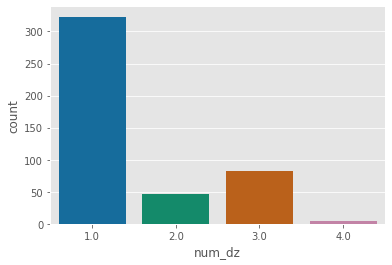

In [249]:
print(common_dz.num_dz.value_counts())
sns.countplot(common_dz.num_dz)


In [259]:
common_dz.num_dz[common_dz.num_dz==4]

gene_sym
C9orf78    4.0
PTGES      4.0
TOR1A      4.0
TOR1B      4.0
USP20      4.0
Name: num_dz, dtype: float64

In [260]:
common_dz.num_dz[common_dz.num_dz==3].sort()

AttributeError: 'Series' object has no attribute 'sort'

In [264]:
common_dz.num_dz[common_dz.num_dz==3].sort_index().index

Index(['ABHD15', 'ACTR1A', 'ANKRD13B', 'ARL3', 'AS3MT', 'ATPAF2', 'BLMH',
       'C10orf32', 'CALHM2', 'CORO6', 'CPD', 'CRLF3', 'CYP17A1', 'DDR1',
       'DNAH1', 'DRG2', 'EFCAB5', 'FLOT1', 'GIT1', 'GLT8D1', 'GLYCTK',
       'GLYCTK-AS1', 'GNL3', 'HCG17', 'HCG18', 'HCG27', 'HCG4B', 'HCG4P3',
       'HCG9', 'HLA-A', 'HLA-F', 'HLA-F-AS1', 'HLA-K', 'HLA-L', 'HLA-V',
       'HLA-W', 'IFITM4P', 'ITIH3', 'ITIH4', 'MICD', 'MICE', 'MUSTN1', 'NEK4',
       'NT5C2', 'NT5DC2', 'PEMT', 'POU5F1', 'PPM1M', 'PPP1R11', 'PSORS1C1',
       'PSORS1C2', 'RFT1', 'RNF39', 'RP11-168J18.6', 'RP11-18I14.10',
       'RP11-18I14.7', 'RP11-68I3.11', 'RP5-1157M23.2', 'RPL23AP1', 'RPP21',
       'SERBP1P3', 'SFXN2', 'SH3PXD2A', 'SMIM4', 'SPCS1', 'SREBF1', 'SSH2',
       'SUZ12P', 'TCF19', 'TEFM', 'TMEM110', 'TRIM26', 'TRIM39', 'TRIM8',
       'TWF2', 'USMG5', 'VARS2', 'WDR82', 'XXbac-BPG283O16.9', 'ZDHHC20P1',
       'ZFP57', 'ZNRD1', 'ZNRD1ASP'],
      dtype='object', name='gene_sym')